# Visualize paralog compensation and collateral loss results, including biological enrichments in hit pairs


In [109]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib.lines import Line2D
from matplotlib_venn import venn3
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from scipy.stats import fisher_exact
from collections import Counter

# Functions and specs

In [7]:
coldict = {
    'compensation': "#00ABF5",
    'collateral_loss': "#FFBC1F",
    'non_hit': "grey",
    'Compensation': "#00ABF5",
    'Collateral loss': "#FFBC1F",
    'Non-hit': "grey",
    'SL': "#800000" 
}

In [8]:
colmap_allcats = {
    'prot': '#A96DAE',    
    'trans': '#5AACA8',  
    'resid': '#C7A238' 
}


# Function to blend colors
def blend_colors(color1, color2, ratio=0.5):
    rgb1 = mcolors.to_rgb(color1)
    rgb2 = mcolors.to_rgb(color2)
    blend = tuple([(1-ratio)*c1 + ratio*c2 for c1, c2 in zip(rgb1, rgb2)])
    return mcolors.to_hex(blend)

color_map_venns = {
    '100': colmap_allcats['prot'],
    '010': colmap_allcats['trans'],
    '001': colmap_allcats['resid'],
    '110': blend_colors(colmap_allcats['prot'], colmap_allcats['trans']),
    '101': blend_colors(colmap_allcats['prot'], colmap_allcats['resid']),
    '011': blend_colors(colmap_allcats['trans'], colmap_allcats['resid']),
    '111': blend_colors(blend_colors(colmap_allcats['prot'], colmap_allcats['trans']), colmap_allcats['resid'])
}

In [9]:
namedict = {'A2_median_neighbour_ess':'Median lost gene neighbour essentiality', 'bg_jaccard':'Biogrid Jaccard index', 'biogrid_dc':'Biogrid degree centrality', 'conservation_score':'Conservation score', 'family_size':'Family size', 'sequence_identity':'Sequence identity', 'string_dc_physical':'STRING degree centrality', 'string_jaccard_physical':'STRING physical Jaccard index'}


In [10]:
def generate_comp_CL_barchart(res_A1A2, filename, colormap, xlim=15,yticks=True):
    fig, ax = plt.subplots(figsize=(6, 4))  
    num_tested = res_A1A2.shape[0]
    num_comp = res_A1A2[res_A1A2.compensation].shape[0]
    num_CL = res_A1A2[res_A1A2.collateral_loss].shape[0]
    per_comp = round((num_comp / num_tested) * 100, 0)
    per_CL = round((num_CL / num_tested) * 100, 0)
    values = [per_CL, per_comp]
    values = [int(x) for x in values]
    counts = [num_CL, num_comp]
    ax.barh(['Collateral loss', 'Compensation'], values, color=[colormap['collateral_loss'], colormap['compensation']], alpha=0.7, edgecolor='black')
    ax.set_xlim(0,xlim)
    for index, (value, count) in enumerate(zip(values, counts)):
        ax.text(value + 0.5, index, f'{value}% ({count})', ha='left', va='center', fontsize=22)
    if xlim==15:
        ax.set_xticks(range(0, 20, 5))  # Reintroducing the xticks
    ax.set_xlabel(f'\n% of {len(res_A1A2)} paralog pairs tested', fontsize=22)  # Adding x-axis label    
    ax.tick_params(axis='x', labelsize=22)
    ax.tick_params(axis='y', labelsize=22)
    if yticks== False:
        ax.set_yticks([])
    plt.savefig(f'../../output/figures/{filename}_compCL.svg', dpi = 120, bbox_inches ='tight')
    plt.show()
    

In [11]:
def HAP1_boxplot(gene_pair, A1A2_df, data, colordict, show_points=True):
    A1A2_df['standard_gene_pair'] = A1A2_df['gene_pair'].apply(lambda x: '_'.join(x.split('_')[0:2]))
    A1A2_df['retained_clone'] = A1A2_df['gene_pair'].apply(lambda x: x.split('_')[-1] if len(x.split('_')) > 2 else '')
    A1, A2 = gene_pair.split('_')[0], gene_pair.split('_')[1]
    row = A1A2_df.loc[A1A2_df['standard_gene_pair'] == gene_pair].iloc[0]
    retained_clone = row['retained_clone']
    if retained_clone:
        full_gene_pair = f"{gene_pair}_{retained_clone}"
    else:
        full_gene_pair = gene_pair
    
    KO_data = data[full_gene_pair][0]
    wt_data = data[full_gene_pair][1]
    if A1A2_df.loc[A1A2_df['gene_pair'] == gene_pair, 'compensation'].values[0]:
        status = 'compensation'
    elif A1A2_df.loc[A1A2_df['gene_pair'] == gene_pair, 'collateral_loss'].values[0]:
        status = 'collateral_loss'
    else:
        status = 'non_hit'
    
    fig, ax = plt.subplots(figsize=(4, 4.5))
    KO_color = colordict[status]
    df = pd.DataFrame({'Category': ['WT'] * len(wt_data) + ['KO'] * len(KO_data),
                       'Abundance': wt_data + KO_data})
    
    sns.boxplot(x='Category', y='Abundance', data=df, ax=ax,
                order=['WT', 'KO'],
                palette={'WT': 'white', 'KO': KO_color},
                linewidth=2.4, showfliers=False, showmeans=False, saturation=1,
                boxprops=dict(alpha=0.8), medianprops=dict(linewidth=2.4, color='black'))
    if show_points:
        sns.stripplot(x='Category', y='Abundance', data=df, order=['WT', 'KO'], color='grey', ax=ax, alpha=0.8, size=3, zorder=0)  
    ax.set_xlim(-0.6, 1.6)  
    
    ax.set_aspect(1.2 / ax.get_data_ratio())  
    ax.set_xlabel(f'{A2} status', fontsize=18)
    ax.set_ylabel(f'{A1} abundance', fontsize=18)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    plt.tight_layout()
    
    fig.set_size_inches(4, 4.5)
    plt.savefig(f'../../output/figures/{gene_pair}_box.svg', dpi=120, bbox_inches = 'tight', pad_inches = 0.1)
    plt.show()
    

In [12]:
def getcat(comp, cl):
    if comp:
        return 'Compensation'
    elif cl:
        return 'Collateral loss'
    else:
        return 'Non-hit'


In [13]:
def draw_venn(prot, trans, resid, figtitle):
    v = venn3([set(prot), set(trans), set(resid)], set_labels = ['Proteomics', 'Transcriptomics', 'Residuals'])
    for id in ['100', '010', '001', '110', '101', '011', '111']:
        if v.get_patch_by_id(id):
            v.get_patch_by_id(id).set_color(color_map_venns[id])

    for text in v.set_labels:
        text.set_fontsize(16)  

    for text2 in v.subset_labels:
        if text2:
            text2.set_fontsize(12)  
#   plt.savefig(f'./newout/results_github/figures/{figtitle}_venn.svg', dpi = 120, bbox_inches = 'tight')
    plt.show()

In [14]:
def make_volcano_plot(df, filename, sigcutoff, colordict, xlim=2, A2=False):
    fig, ax = plt.subplots(figsize=(10, 6))
    df['neg_log10_p_adj'] = -np.log10(df['ols_p'] if A2 else df['p_adj'])
    significance_cutoff = -np.log10(sigcutoff)
    if A2:
        df['category'] = df['backed']
        df['category'] = df['category'].replace(True, 'Loss associated with protein drop')
        df['category'] = df['category'].replace(False, 'Loss not associated with protein drop')    
        setpalette = {'Loss associated with protein drop': 'grey', 'Loss not associated with protein drop':'white'}    
    else:
        setpalette = {'Compensation': colordict['Compensation'], 'Collateral loss': colordict['Collateral loss'], 'Non-hit': colordict['Non-hit']}
        df['category'] = np.select(
            [(df['neg_log10_p_adj'] > significance_cutoff) & (df['ols_coef'] > 0), 
             (df['neg_log10_p_adj'] > significance_cutoff) & (df['ols_coef'] < 0)],
            ['Compensation', 'Collateral loss'], default='Non-hit')
    ax.set_facecolor('#f0f0f0' if A2 else 'white')
    sns.scatterplot(x='ols_coef', y='neg_log10_p_adj', hue='category', data=df,
                    palette=setpalette, edgecolor='black' if A2 else 'white', linewidth=1, ax=ax)
    ax.axhline(y=significance_cutoff, color='grey', linestyle='--', linewidth=1)
    ax.axvline(x=0, color='grey', linestyle='--', linewidth=1)
    ax.set_xlabel('\nOLS Coefficient', fontsize=15)
    ax.set_ylabel('-log10(P-value)\n', fontsize=15)
    if len(df) > 50 or A2:
        ax.set_ylim([-1, df['neg_log10_p_adj'].max() * 1.05])
    if xlim:
        ax.set_xlim([-xlim, xlim])
    else:
        ax.set_xlim([-df['ols_coef'].abs().max() * 1.2, df['ols_coef'].abs().max() * 1.2])
    legend_labels = ['Loss associated w significant protein drop', 'Loss not associated w significant protein drop'] if A2 else ['Compensation', 'Collateral loss', 'Non-hit']
    legend_colors = ['grey', 'white'] if A2 else ['#00ABF5', 'darkorange', 'grey']
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, 
                                 markerfacecolor=color, markeredgecolor='black' if A2 else 'white') 
                      for label, color in zip(legend_labels, legend_colors)]
    ax.legend(handles=legend_handles, title=None, loc='upper right' if A2 else 'upper left')
    plt.savefig(f'../../output/figures/volcano_{filename}{"_A2" if A2 else ""}.svg', dpi=150, bbox_inches='tight')
    plt.show()

In [15]:
def CPTAC_boxplot(pair, results_df, data_df, loss_df, colordict, measure, plottingA2 = False, show_points=True, ess=False):
    fig, ax = plt.subplots(figsize=(4, 4.5))
    if ess == False:
        if plottingA2 == False:
            if pair not in results_df['gene_pair'].values:
                ax.text(0.5, 0.5, 'Not tested', ha='center', va='center', fontsize=20, transform=ax.transAxes)
            else:
                status = 'non_hit'
                if pair in results_df[results_df['compensation']].gene_pair.values:
                    status = 'compensation'
                elif pair in results_df[results_df['collateral_loss']].gene_pair.values:
                    status = 'collateral_loss'
    else:
        status = 'SL'
    
    if ess or pair in results_df['gene_pair'].values or plottingA2 == True:
        A1, A2 = pair.split("_")
        data_sliced = data_df.loc[:, A1].reset_index().rename(columns={A1: f'A1_{measure}'}).rename(columns={'cell_line':'sample_ID', 'index': 'sample_ID'})
        loss_sliced = loss_df.loc[A2, :].reset_index().rename(columns={A2: 'A2_lost'}).rename(columns={'index': 'sample_ID'})
        df = data_sliced.merge(loss_sliced, on='sample_ID', how='inner').dropna()
        df['A2_lost'] = df['A2_lost'].apply(lambda x: 'Lost' if x else 'WT')
        category_order = ['WT', 'Lost']
        if plottingA2 == True:
            lostcol = 'white'
        else:
            lostcol = colordict[status]
        palette = {'WT': 'white', 'Lost': lostcol}
        
        sns.boxplot(y=f'A1_{measure}', x='A2_lost', data=df, ax=ax,
                    order=category_order,
                    palette=palette,
                    linewidth=2.4, showfliers=False, showmeans=False, saturation=1,
                    boxprops=dict(alpha=0.8), medianprops=dict(linewidth=2.4, color='black'))
        
        if show_points:
            sns.stripplot(y=f'A1_{measure}', x='A2_lost', data=df, order=category_order, 
                          color='grey', ax=ax, alpha=0.8, size=3, zorder=0)
        
        ax.set_xlabel(f'{A2} status', fontsize=20)
        ax.set_ylabel(f'{A1} {measure}', fontsize=20)
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=15)
    else:
        ax.text(0.5, 0.5, 'Not tested', ha='center', va='center', fontsize=20, transform=ax.transAxes)
    plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)
    ax.set_xlim(-0.5, 1.5)
   # plt.tight_layout()
    
    if ess:
        filenamestr =f'../../output/figures/{pair}_box_ESS.svg'
    else:
        filenamestr =f'../../output/figures/{pair}_box.svg'      
    
    plt.savefig(filenamestr, dpi=120)
    plt.show()
    

In [16]:
def make_overlap_bar_chart(overlap_df, interaction_dataset, xlim, xaxislabel, colordictloc=coldict, filename='', directional=False):
    if directional:
        pairvar = 'gene_pair'
    else:
        pairvar = 'sorted_gene_pair'
    overlap_df = overlap_df[(overlap_df.dataset == 'pancan') & (overlap_df.FDR_threshold == 0.05)]
    comp_total = overlap_df[overlap_df['category'] == 'Compensation'][pairvar].unique()

    comp_tested_in_interaction = overlap_df[(
        overlap_df[pairvar].isin(comp_total)) & (~overlap_df[
        interaction_dataset].isna())][pairvar].unique()
    comp_tested_in_interaction_and_passed = overlap_df[(
        overlap_df[pairvar].isin(comp_tested_in_interaction)) & (
        overlap_df[interaction_dataset] == True)][pairvar].unique()
    cl_total = overlap_df[
        overlap_df['category'] == 'Collateral loss'][pairvar].unique()
        
    cl_tested_in_interaction = overlap_df[(
        overlap_df[pairvar].isin(cl_total)) & (~overlap_df[
        interaction_dataset].isna())][pairvar].unique()
        
    cl_tested_in_interaction_and_passed = overlap_df[(
        overlap_df[pairvar].isin(cl_tested_in_interaction)) & (
        overlap_df[interaction_dataset] == True)][pairvar].unique()

    non_total = overlap_df[overlap_df['category'] == 'Non-hit'][pairvar].unique()
        
    non_tested_in_interaction = overlap_df[(overlap_df[pairvar].isin(non_total)) & (~overlap_df[
        interaction_dataset].isna())][pairvar].unique()
        
    non_tested_in_interaction_and_passed = overlap_df[(
        overlap_df[pairvar].isin(non_tested_in_interaction)) & (
        overlap_df[interaction_dataset] == True)][pairvar].unique()
    
    def calculate_percentage(numerator, denominator):
        if denominator > 0:
            return (numerator / denominator) * 100
        else:
            return np.nan
        
    comp_percent_interaction_true = calculate_percentage(len(comp_tested_in_interaction_and_passed), len(comp_tested_in_interaction))
    cl_percent_interaction_true = calculate_percentage(len(cl_tested_in_interaction_and_passed), len(cl_tested_in_interaction))
    non_percent_interaction_true = calculate_percentage(len(non_tested_in_interaction_and_passed), len(non_tested_in_interaction))

    categories = ['Collateral loss', 'Non-hits', 'Compensation']
        
    values = [cl_percent_interaction_true, non_percent_interaction_true, comp_percent_interaction_true]
        
    counts = [len(cl_tested_in_interaction_and_passed), len(non_tested_in_interaction_and_passed), len(comp_tested_in_interaction_and_passed)]
    colors = [colordictloc['Collateral loss'], colordictloc['Non-hit'], colordictloc['Compensation']]

    fig, ax = plt.subplots(figsize=(6, 4))
    
    ax.barh(categories, values, color=colors, alpha=1, edgecolor='black')
    if xlim < 30:
        tick_interval = 5
    elif xlim > 70:
        tick_interval = 20
    else:
        tick_interval = 10

    xticks = np.arange(0, xlim + tick_interval, tick_interval)
    if xticks[-1] > xlim:
        xticks = xticks[:-1] 
    elif xticks[-1] < xlim:
        xticks = np.append(xticks, xlim - (xlim % tick_interval) + tick_interval)

    ax.set_xlim(0, xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels([f'{int(x)}' for x in xticks])
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)

    ax.set_xlabel(f'\n{xaxislabel}', fontsize=18)

    def format_percentage(value):
        if value >= 1:
            return f'{int(value)}%'
        elif value > 0:
            return f'{value:.1g}%' 
        else:
            return '0%'

    for index, (value, count) in enumerate(zip(values, counts)):
        formatted_value = format_percentage(value)
        ax.text(value + 0.5, index, f'{formatted_value} ({count})', ha='left', va='center', fontsize=18)

    plt.savefig(f'../../output/figures/{filename}_overlaps.svg', dpi=120, bbox_inches='tight')
    plt.show()

In [17]:
def combined_ttest_and_boxplot(colname, df, filename, ylim=None, coldict=None, namedict=None):
    ylab = namedict[colname]
    df2 = df.drop_duplicates(subset='sorted_gene_pair')
    compvals = df2[df2.compensation].dropna()[colname].to_list()
    clvals = df2[df2.collateral_loss].dropna()[colname].to_list()
    nonvals = df2[df2.category == 'non_hit'].dropna()[colname].to_list()
    comp_non_pvalue = stats.ttest_ind(compvals, nonvals).pvalue
    cl_non_pvalue = stats.ttest_ind(clvals, nonvals).pvalue
    df2['category'] = df2['category'].replace({'compensation': 'Compensation',
                                               'collateral_loss': 'Collateral loss',
                                               'non_hit': 'Non-hit'})
    category_order = ['Compensation', 'Non-hit', 'Collateral loss']
    df2['category'] = pd.Categorical(df2['category'], categories=category_order, ordered=True)
    plt.figure(figsize=(5, 4), dpi=120)
    box_plot = sns.boxplot(x='category', y=colname, data=df2, palette=coldict, width=0.6, 
                           flierprops={'marker': 'none'})
    plt.xlabel('')
    plt.xticks(fontsize=14)
    whiskers = [item.get_ydata() for item in box_plot.lines if len(item.get_ydata()) == 2]
    whisker_mins = [min(whisker) for whisker in whiskers]
    whisker_maxs = [max(whisker) for whisker in whiskers]
    ymin = min(whisker_mins)
    ymax = max(whisker_maxs)
    y_range = ymax - ymin
    padding = 0.1 * y_range
    if '\n' not in ylab:
        if len(ylab) > 30:  
            words = ylab.split()
            char_count = 0
            first_line = []
            for word in words:
                if char_count + len(word) <= len(ylab) // 2:
                    first_line.append(word)
                    char_count += len(word) + 1  # +1 for the space
                else:
                    break
            ylab = ' '.join(first_line) + '\n' + ' '.join(words[len(first_line):])
    plt.ylabel(f'{ylab}', fontsize=18)
    plt.yticks(fontsize=13)
    def add_pvalue(pvalue, x1, x2, y, h):
        pvalue_rounded = f"{pvalue:.2e}" if pvalue < 0.01 else f"{pvalue:.2f}"
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='black')
        plt.text((x1+x2)*.5, y+h*1.5, f"p = {pvalue_rounded}", ha='center', va='bottom', fontsize=10)
    if ylim is None:
        plt.ylim(ymin - padding, ymax + padding + y_range * 0.3)
        pvalue_y = ymax + y_range * 0.05
        add_pvalue(comp_non_pvalue, 0, 1, pvalue_y, y_range * 0.03)
        add_pvalue(cl_non_pvalue, 1, 2, pvalue_y + y_range * 0.1, y_range * 0.03)
    else:
        plt.ylim(0.1, 1.1)  # Set y-axis limits from 0.1 to 1.1
        yticks = plt.gca().get_yticks()
        visible_ticks = [tick for tick in yticks if 0.1 <= tick <= 1.0]
        plt.gca().set_yticks(visible_ticks)
        plt.gca().set_yticklabels([f'{tick:.2f}' if tick <= ylim else '' for tick in visible_ticks])
        # Make ticks above ylim invisible
        for tick in plt.gca().yaxis.get_major_ticks():
            if float(tick.get_loc()) > ylim:
                tick.tick1line.set_visible(False)
        pvalue_y = ymax + y_range * 0.05
        add_pvalue(comp_non_pvalue, 0, 1, pvalue_y, y_range * 0.03)
        add_pvalue(cl_non_pvalue, 1, 2, 0.92, y_range * 0.03)  # CL p-value position as before
    
    plt.savefig(f'../../output/figures/{filename}_overlapbox.svg', dpi=120, bbox_inches='tight')
    plt.show()

In [18]:
def plot_OR(input_hit_type, FDR, df1, df2=None, df3=None, df1_label='Dataset 1', df2_label='Dataset 2', df3_label='Dataset 3', displaydf=False, ylabel_dict=None, force_order=False, rightxlim=None):
    
    datasets_to_plot = ['strict_comb_hit', 'in_PC_CORUM_both', 'in_PC_CORUM_essential', 'lenient_comb_hit', 'bronze_standard_SL', 'in_PC_EBI', 'in_PC_humap', 'in_PC_CORUM', 'famsize2', 'closest_pair', 'interating_pair']
    if df2 is None:
        colmap = { 'df1': '#C76B8F'}
    else:
        colmap = {
            'df1': '#A96DAE',
            'df3': '#5AACA8',
            'df2': '#C7A238'
        }

    def process_df(df, label, hittype=None):
        if hittype == 'compensation':
            df = df[df.interaction_dataset != 'other_dir_cl']
        elif hittype == 'collateral_loss':
            df = df[df.interaction_dataset != 'other_dir_comp']
        df['sig'] = (df['FET_p'] < 0.05) & (df['FET_p_adj'] < FDR)
        df['index'] = df['interaction_dataset'] + '_' + df['hit_type']
        df = df[(df['FDR_threshold'] == 0.05) & (df['hit_type'] == hittype if hittype else True)].sort_values(by='FET_OR', ascending=True)
        if isinstance(colmap[label], dict):
            df['color'] = df['hit_type'].map(colmap[label])
        else:
            df['color'] = colmap[label]
        return df
    
    single_dataset = df2 is None and df3 is None
    
    if single_dataset:
        df1_filtered_sorted = process_df(df1, 'df1')
    else:
        df1_filtered_sorted = process_df(df1, 'df1', input_hit_type)
    
    merged_df = df1_filtered_sorted[['index', 'FET_OR', 'color', 'sig', 'interaction_dataset', 'hit_type']].rename(columns={'FET_OR': 'FET_OR_df1', 'color': 'color_df1', 'sig': 'sig_df1'})
    
    if df2 is not None:
        df2_filtered_sorted = process_df(df2, 'df2', input_hit_type)
        merged_df = merged_df.merge(df2_filtered_sorted[['index', 'FET_OR', 'color', 'sig']], on='index', suffixes=('_df1', '_df2')).rename(columns={'FET_OR': 'FET_OR_df2', 'color': 'color_df2', 'sig': 'sig_df2'})
    if df3 is not None:
        df3_filtered_sorted = process_df(df3, 'df3', input_hit_type)
        merged_df = merged_df.merge(df3_filtered_sorted[['index', 'FET_OR', 'color', 'sig']], on='index', suffixes=('', '_df3')).rename(columns={'FET_OR': 'FET_OR_df3', 'color': 'color_df3', 'sig': 'sig_df3'})
    
    if 'FET_OR_df3' in merged_df.columns:
        merged_df = merged_df.sort_values('FET_OR_df3', ascending=True)
    if datasets_to_plot is not None:
        merged_df = merged_df[merged_df['interaction_dataset'].isin(datasets_to_plot)]
        if force_order:
            sorter = {dataset: i for i, dataset in enumerate(reversed(datasets_to_plot))}
            merged_df.sort_values(by="interaction_dataset", key=lambda column: column.map(sorter), inplace=True)
    merged_df['interaction_dataset'] = merged_df['interaction_dataset'].apply(lambda x: ydict[x])
    interaction_datasets = merged_df['interaction_dataset']
    fig, ax = plt.subplots(figsize=(7, 8))
    
    def plot_dataset(df_col, color_col, sig_col):
        non_sig = merged_df[~merged_df[sig_col]]
        sig = merged_df[merged_df[sig_col]]
        ax.scatter(non_sig[df_col], non_sig['interaction_dataset'], facecolors='none', edgecolors=non_sig[color_col], marker='o', s=150, linewidth=2)
        ax.scatter(sig[df_col], sig['interaction_dataset'], color=sig[color_col], marker='o', s=200, zorder=10)
    
    plot_dataset('FET_OR_df1', 'color_df1', 'sig_df1')
    if df2 is not None and 'FET_OR_df2' in merged_df.columns:
        plot_dataset('FET_OR_df2', 'color_df2', 'sig_df2')
    if df3 is not None and 'FET_OR_df3' in merged_df.columns:
        plot_dataset('FET_OR_df3', 'color_df3', 'sig_df3')
    
    ax.set_xlabel("\nFishers Exact Test Odds Ratio", fontsize=15)
    ax.set_ylabel("", fontsize=14)
    ax.axvline(x=1, color='grey', linestyle='--')
    ax.tick_params(axis='both', which='major', labelsize=17)
    if rightxlim is None:
        rightxlim = 7
    ax.set_xlim(left=-0.1, right=rightxlim)
    ax.tick_params(axis='y', labelsize=16)

    legend_elements = []
    
    if single_dataset:        
        legend_elements.extend([
            Rectangle((0, 0), 1, 1, color='#00ABF5', label='Compensation'),
            Rectangle((0, 0), 1, 1, color='#FFBC1F', label='Collateral Loss')
        ])
    else:
        datasets = [df1, df2, df3]
        labels = [df1_label, df2_label, df3_label]
        colors = [colmap['df1'], colmap['df2'], colmap['df3']]
        
        for dataset, label, color in zip(datasets, labels, colors):
            if dataset is not None:
                legend_elements.append(Rectangle((0, 0), 1, 1, color=color['compensation'] if isinstance(color, dict) else color, label=label))
    ax.set_facecolor('#F7F7F7')  # Light grey color
    legend_elements.extend([
        Line2D([0], [0], marker='o', color='grey', label='p < 0.05', markersize=10, linestyle=''),
        Line2D([0], [0], marker='o', color='grey', label='p ≥ 0.05', markersize=10, linestyle='', linewidth=2, markerfacecolor='none')
    ])
    
    ax.legend(bbox_to_anchor=(0.56, -0.01), loc='lower left', handles=legend_elements, fontsize=14)    
    plt.savefig('../../output/figures/OR_comparison.svg', dpi=200, bbox_inches='tight')
    plt.show()

In [19]:
def get_postransreg_for_plot(gene_pair, resid_comp, prot_comp, trans_comp, never_hits):
    if ((gene_pair in resid_comp) | ((gene_pair in prot_comp)) & (gene_pair not in trans_comp)):
        return 'post_trans'
    elif (gene_pair in trans_comp) & (gene_pair not in resid_comp):
        return 'trans'
    elif gene_pair in list(never_hits):
        return 'non_hit'
    else:
        return np.nan

In [110]:
def get_complex_sizes(all_corum_prots, all_corum):
    complex_sizes = {}
    for prots in (all_corum_prots):
        largest_complex_size = 0
        for complexes in (all_corum[all_corum.gene_symbol == prots].complex.to_list()):
            if len(all_corum[all_corum.complex == complexes]) > largest_complex_size:
                largest_complex_size = len(all_corum[all_corum.complex == complexes])
        complex_sizes[prots] = largest_complex_size
    return complex_sizes

In [21]:
def create_ubsite_df(not_corum_prots, all_corum_prots, big_complex_prots, all_post_trans_A1s, all_trans_A1s, all_non_hit_A1s, ubdict):
    ubtuples = []
    for protein in not_corum_prots:
        ubtuples.append((protein, 'Not in CORUM'))
    for protein in all_corum_prots:
        if protein in big_complex_prots:
            ubtuples.append((protein, 'CORUM complex size >10'))
        else:
            ubtuples.append((protein, 'In CORUM'))
    for protein in all_post_trans_A1s:
        ubtuples.append((protein, 'Post-trans comp'))
    for protein in all_trans_A1s:
        ubtuples.append((protein, 'Trans comp'))
    for protein in all_non_hit_A1s:
        ubtuples.append((protein, 'Non-hits'))
    
    ubsite_df = pd.DataFrame(ubtuples, columns=['Protein', 'Category'])
    ubsite_df['num_ub_sites'] = ubsite_df['Protein'].apply(lambda x: ubdict[x] if x in list(ubdict.keys()) else 0)
    
    category_map = {
        'CORUM complex size >10': 'CORUM\ncomplex\nsize >10',
        'In CORUM': 'In\nCORUM',
        'Post-trans comp': 'Post-trans\ncomp',
        'Trans comp': 'Trans\ncomp',
        'Non-hits': 'Non-hits',
        'Not in CORUM': 'Not\nin CORUM'
    }
    ubsite_df['Category'] = ubsite_df['Category'].map(category_map)
    return ubsite_df

In [22]:
def mann_whitney_test(x, y):
    x = x.dropna()
    y = y.dropna()
    if len(x) == 0 or len(y) == 0:
        return np.nan
    statistic, p_value = stats.mannwhitneyu(x, y, alternative='two-sided')
    return p_value

In [23]:
def add_stat_annotation(ax, data, category_order, category_map):
    y_max = ax.get_ylim()[1]
    y_range = y_max - ax.get_ylim()[0]
    comparisons = [(category_order[i], category_order[i+1]) for i in range(len(category_order)-1)]
    for i, (cat1, cat2) in enumerate(comparisons):
        cat1_data = data[data['Category'] == category_map[cat1]]['num_ub_sites']
        cat2_data = data[data['Category'] == category_map[cat2]]['num_ub_sites']
        p_value = mann_whitney_test(cat1_data, cat2_data)
        x1 = i
        x2 = i + 1
        y = y_max + (i + 1) * 0.05 * y_range
        ax.plot([x1, x1, x2, x2], [y, y + 0.02 * y_range, y + 0.02 * y_range, y], lw=1, c='black')
        if np.isnan(p_value):
            ax.text((x1 + x2) * 0.5, y + 0.03 * y_range, "N/A", ha='center', va='bottom', fontsize=10)
        else:
            ax.text((x1 + x2) * 0.5, y + 0.03 * y_range, f'p = {p_value:.2e}', ha='center', va='bottom', fontsize=9)

In [24]:
def plot_ubiquitination_sites(ubsite_df, category_order, color_dict, add_p_values=True, save=False):
    plt.figure(figsize=(7,5))
    
    # Use category_order directly for plotting
    ax = sns.boxplot(x='Category', y='num_ub_sites', data=ubsite_df,
                     order=category_order, 
                     showfliers=False, palette=color_dict, width=0.6)

    for i, box in enumerate(ax.patches):
        if category_order[i] in color_dict:
            box.set_facecolor(color_dict[category_order[i]])
            box.set_edgecolor('black')

    if add_p_values:
        add_stat_annotation(ax, ubsite_df, category_order, color_dict)

    plt.ylabel('Number of Ubiquitination Sites', fontsize=17)
    plt.xlabel('')
    ax.set_xticklabels(category_order, rotation=0, ha='center')
    ax.tick_params(axis='y', which='major', labelsize=14)
    ax.tick_params(axis='x', which='major', labelsize=12)
    plt.tight_layout()
    sns.despine()
    
    if save:
        plt.ylim(0,60)
        plt.savefig('../../output/figures/full_ub_plot_updated.png', dpi=150, bbox_inches='tight')
    else:
        plt.show()

# Also update the add_stat_annotation function
def add_stat_annotation(ax, data, category_order, color_dict):
    y_max = ax.get_ylim()[1]
    y_range = y_max - ax.get_ylim()[0]
    comparisons = [(category_order[i], category_order[i+1]) for i in range(len(category_order)-1)]
    for i, (cat1, cat2) in enumerate(comparisons):
        cat1_data = data[data['Category'] == cat1]['num_ub_sites']
        cat2_data = data[data['Category'] == cat2]['num_ub_sites']
        p_value = mann_whitney_test(cat1_data, cat2_data)
        x1 = i
        x2 = i + 1
        y = y_max + (i + 1) * 0.05 * y_range
        ax.plot([x1, x1, x2, x2], [y, y + 0.02 * y_range, y + 0.02 * y_range, y], lw=1, c='black')
        if np.isnan(p_value):
            ax.text((x1 + x2) * 0.5, y + 0.03 * y_range, "N/A", ha='center', va='bottom', fontsize=10)
        else:
            ax.text((x1 + x2) * 0.5, y + 0.03 * y_range, f'p = {p_value:.2e}', ha='center', va='bottom', fontsize=9)

# HAP1 figures

In [25]:
HAP1_results = pd.read_csv('../../output/output_HAP1/HAP1_paralogtest_results.csv', index_col = 0)
HAP1_results[:2]

,gene_pair,t_stat,p_val,p_values_adjusted,compensation,collateral_loss
0,ARFGAP3_ARFGAP2,3.149354,0.007101,0.023331,True,False
1,ARFGAP2_ARFGAP3,-0.185587,0.855430,0.894314,False,False


## Figure 1

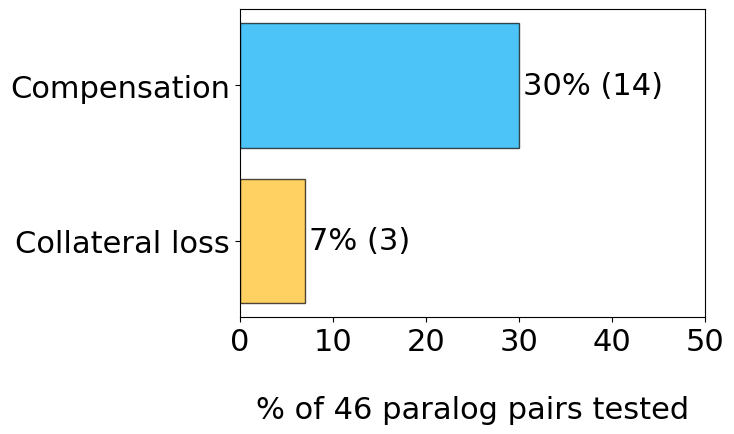

In [26]:
generate_comp_CL_barchart(HAP1_results, 'HAP1', colormap=coldict, xlim=50)

In [27]:
HAP1_prot_renamed = pd.read_csv('../../output/output_HAP1/HAP1_prot_renamed.csv').set_index('gene_name')

data = {}

for pair in HAP1_results.gene_pair.to_list():
    splitlist = pair.split('_')
    A1 = splitlist[0]
    if len(splitlist) == 2:
        A2 = splitlist[1]
    elif len(splitlist) == 3:
        A2 = splitlist[1] + '_' + splitlist[2]
    genelist = [x for x in HAP1_prot_renamed.index.to_list() if ((f';{A1}' in x) or (f'{A1};' in x) or (x == A1))]
    if len(genelist)>0:
        gene_index = genelist[0]
    KO_samples = [x for x in HAP1_prot_renamed.columns.to_list() if A2 in x]
    KO_quants = HAP1_prot_renamed[(HAP1_prot_renamed.index == gene_index)][KO_samples].iloc[0].values.tolist()
    WT_quants = HAP1_prot_renamed[(HAP1_prot_renamed.index == gene_index)][[x for x in HAP1_prot_renamed.columns.to_list() if 'WT_' in x]].iloc[0].values.tolist()
    KO_quants = [x for x in KO_quants if np.isnan(x) == False]
    WT_quants = [x for x in WT_quants if np.isnan(x) == False]
    data[pair] = KO_quants, WT_quants


/tmp/ipykernel_312538/1992976027.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y='Abundance', data=df, ax=ax,


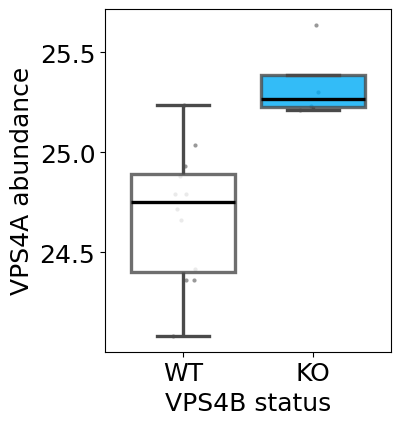

In [28]:
HAP1_boxplot('VPS4A_VPS4B', HAP1_results, data, coldict)

/tmp/ipykernel_312538/1992976027.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y='Abundance', data=df, ax=ax,


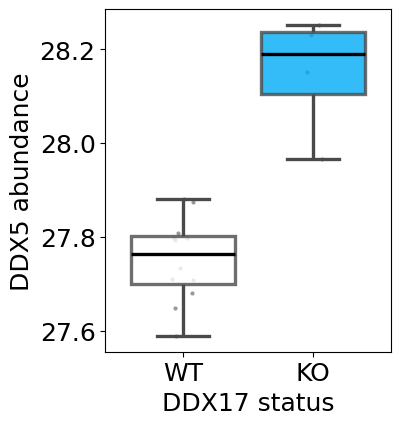

In [29]:
HAP1_boxplot('DDX5_DDX17', HAP1_results, data, coldict)

/tmp/ipykernel_312538/1992976027.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y='Abundance', data=df, ax=ax,


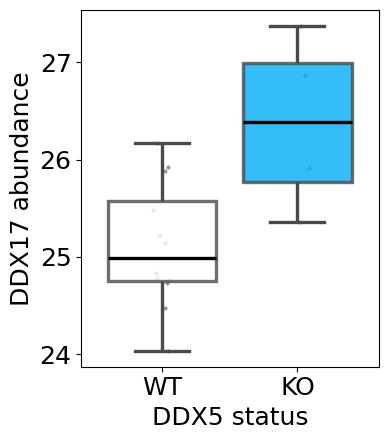

In [30]:
HAP1_boxplot('DDX17_DDX5', HAP1_results, data, coldict)


/tmp/ipykernel_312538/1992976027.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y='Abundance', data=df, ax=ax,


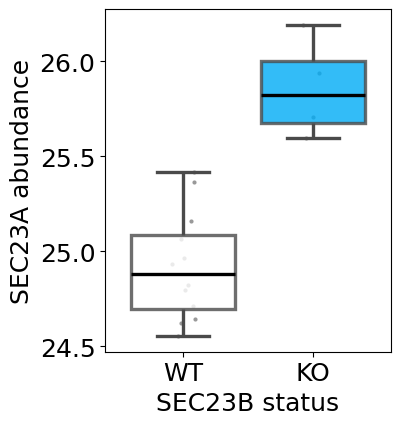

In [31]:
HAP1_boxplot('SEC23A_SEC23B', HAP1_results, data, coldict)


/tmp/ipykernel_312538/1992976027.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y='Abundance', data=df, ax=ax,


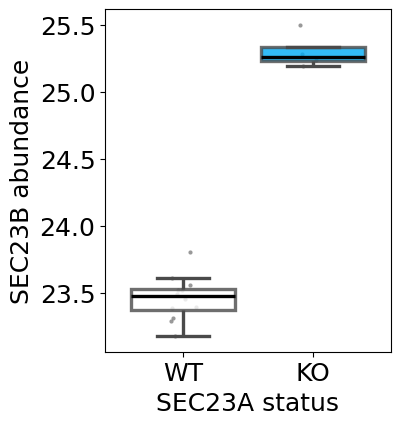

In [32]:
HAP1_boxplot('SEC23B_SEC23A', HAP1_results, data, coldict)


/tmp/ipykernel_312538/1992976027.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y='Abundance', data=df, ax=ax,


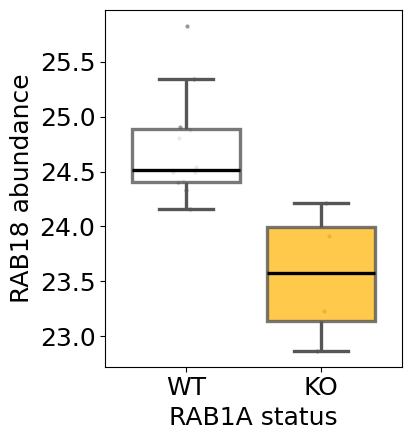

In [33]:
HAP1_boxplot('RAB18_RAB1A', HAP1_results, data, coldict)


# CPTAC Figures

## Figure 2

In [84]:
prot_res = pd.read_csv('../../output/output_CPTAC/prot/paralog_tests_prot.csv', index_col=0)
trans_res = pd.read_csv('../../output/output_CPTAC/trans/paralog_tests_trans.csv', index_col=0)
resid_res = pd.read_csv('../../output/output_CPTAC/prot_residual/paralog_tests_prot_residual.csv', index_col=0)

protcomp = prot_res[prot_res.compensation].gene_pair.to_list()
protcl = prot_res[prot_res.collateral_loss].gene_pair.to_list()
transcomp = trans_res[trans_res.compensation].gene_pair.to_list()
transcl = trans_res[trans_res.collateral_loss].gene_pair.to_list()
residcomp = resid_res[resid_res.compensation].gene_pair.to_list()
residcl = resid_res[resid_res.collateral_loss].gene_pair.to_list()

prot_res['category'] = prot_res.apply(lambda row: getcat(row['compensation'], row['collateral_loss']), axis=1)
trans_res['category'] = trans_res.apply(lambda row: getcat(row['compensation'], row['collateral_loss']), axis=1)
resid_res['category'] = resid_res.apply(lambda row: getcat(row['compensation'], row['collateral_loss']), axis=1)


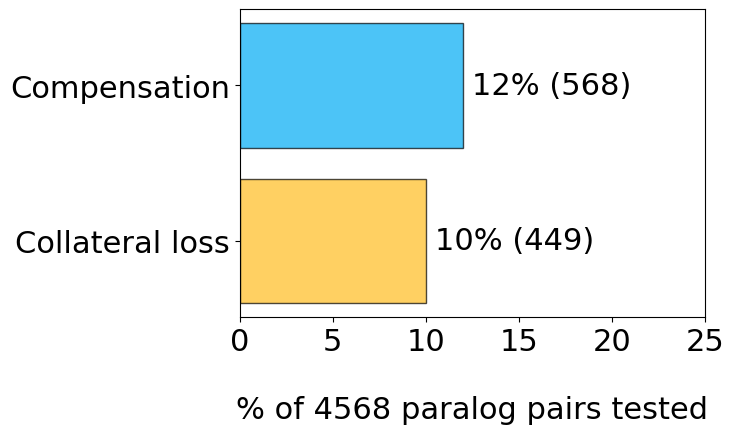

In [35]:
generate_comp_CL_barchart(prot_res, 'prot', colormap=coldict, xlim=25)

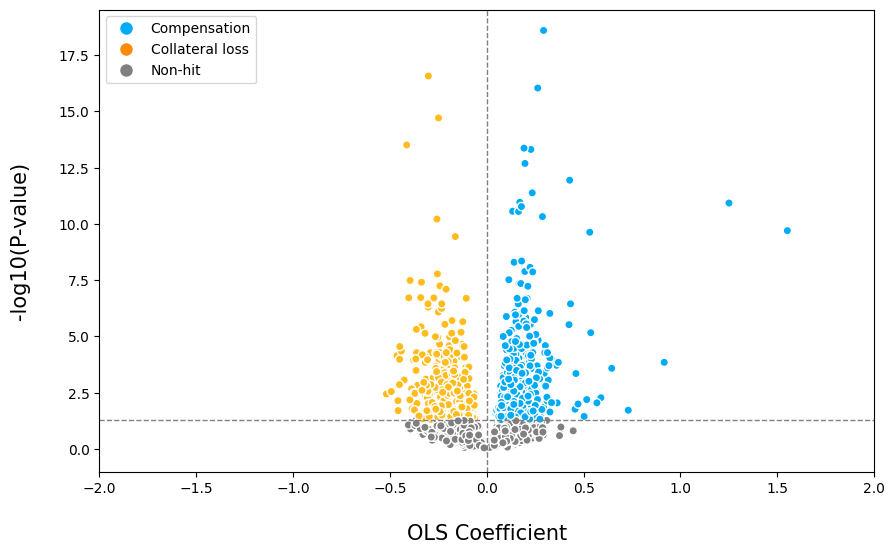

In [36]:
make_volcano_plot(prot_res, filename = 'prot', sigcutoff = 0.05, colordict = coldict)


In [37]:
# We use this for plotting to account for the fact that the model calling compensation and collateral loss
# has lineage/study and self-copy number as covariates

cptac_prot_minus_studycn = pd.read_csv('../../data/CPTAC/prot_study_CN_resid.csv')
cptac_prot_minus_studycn = cptac_prot_minus_studycn.pivot(index='Sample', columns='Gene', values='Residuals')
cptac_prot_minus_studycn.index.name = 'sample_ID'
cptac_prot_minus_studycn.columns.name = ''
cptac_prot_minus_studycn[:2]

,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADAT,...,ZSWIM9,ZUP1,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
sample_ID,,,,,,,,,,,,,,,,,,,,,
01BR001,0.629684,NaN,0.496480,-0.727816,NaN,NaN,0.136395,-0.000409,NaN,0.797313,...,NaN,NaN,-0.152120,0.291223,-0.085828,1.233326,0.115637,0.186772,-0.707190,-0.090611
01BR008,-0.493148,NaN,0.026892,1.193296,NaN,NaN,0.163873,-0.847631,NaN,NaN,...,NaN,NaN,0.028238,0.390215,0.333120,0.926566,-0.158997,-0.273160,-0.035919,0.151976


In [40]:
A2_lost = pd.read_csv('../../output/output_CPTAC/prot/A2_lost.csv').rename(columns = {'Unnamed: 0':'gene_name'}).set_index('gene_name')
A2_lost[:2]

/tmp/ipykernel_312538/1444203025.py:1: DtypeWarning: Columns (19,37,43,46,52,158,206,240,241,253,287,293,349,357,358,360,363,392,395,396,397,400,412,418,445,484,505,514,522,523,555,564,565,582,620,632,644,710,809,831,835,840,857,889,911) have mixed types. Specify dtype option on import or set low_memory=False.
  A2_lost = pd.read_csv('../../output/output_CPTAC/prot/A2_lost.csv').rename(columns = {'Unnamed: 0':'gene_name'}).set_index('gene_name')


,01BR001,01BR008,01BR010,01BR015,01BR017,01BR018,01BR020,01BR023,01BR025,01BR026,...,C3N-04273,C3N-04275,C3N-04276,C3N-04277,C3N-04278,C3N-04279,C3N-04280,C3N-04282,C3N-04283,C3N-04611
gene_name,,,,,,,,,,,,,,,,,,,,,
POLR2B,NaN,False,False,False,False,False,False,NaN,False,False,...,True,False,False,False,True,False,False,False,False,False
APPL1,False,False,False,False,False,True,True,False,False,False,...,True,False,True,False,False,True,False,False,False,False


/tmp/ipykernel_312538/4029397534.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=f'A1_{measure}', x='A2_lost', data=df, ax=ax,


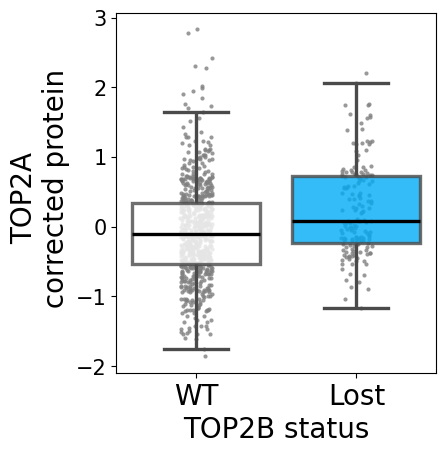

In [41]:
CPTAC_boxplot('TOP2A_TOP2B', prot_res, cptac_prot_minus_studycn, A2_lost, coldict, '\n corrected protein')

/tmp/ipykernel_312538/4029397534.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=f'A1_{measure}', x='A2_lost', data=df, ax=ax,


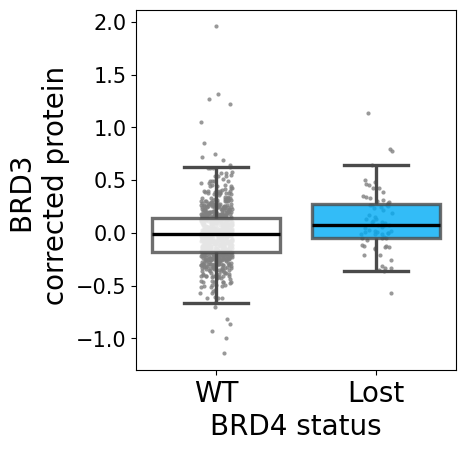

In [42]:
CPTAC_boxplot('BRD3_BRD4', prot_res, cptac_prot_minus_studycn, A2_lost, coldict, '\n corrected protein')

/tmp/ipykernel_312538/4029397534.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=f'A1_{measure}', x='A2_lost', data=df, ax=ax,


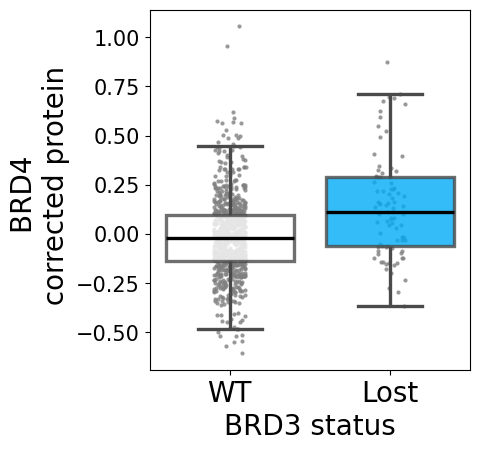

In [43]:
CPTAC_boxplot('BRD4_BRD3', prot_res, cptac_prot_minus_studycn, A2_lost, coldict, '\n corrected protein')

/tmp/ipykernel_312538/4029397534.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=f'A1_{measure}', x='A2_lost', data=df, ax=ax,


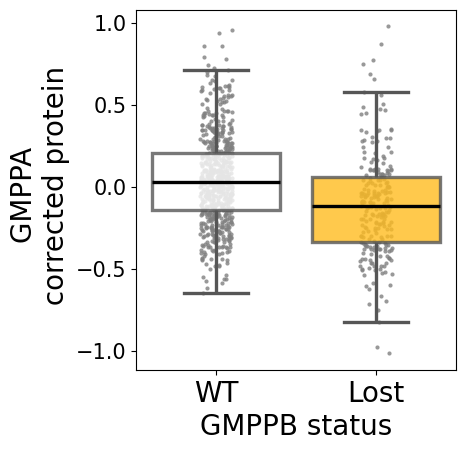

In [44]:
CPTAC_boxplot('GMPPA_GMPPB', prot_res, cptac_prot_minus_studycn, A2_lost, coldict, '\n corrected protein')

/tmp/ipykernel_312538/4029397534.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=f'A1_{measure}', x='A2_lost', data=df, ax=ax,


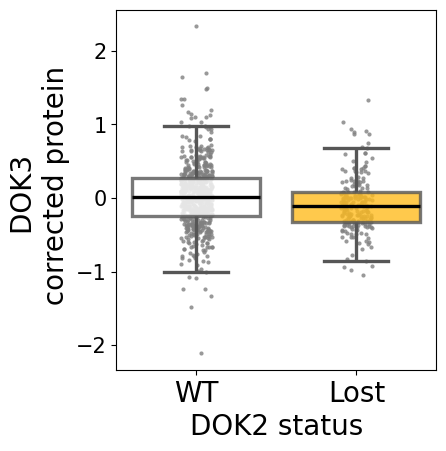

In [45]:
CPTAC_boxplot('DOK3_DOK2', prot_res, cptac_prot_minus_studycn, A2_lost, coldict, '\n corrected protein')

/tmp/ipykernel_312538/4029397534.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=f'A1_{measure}', x='A2_lost', data=df, ax=ax,


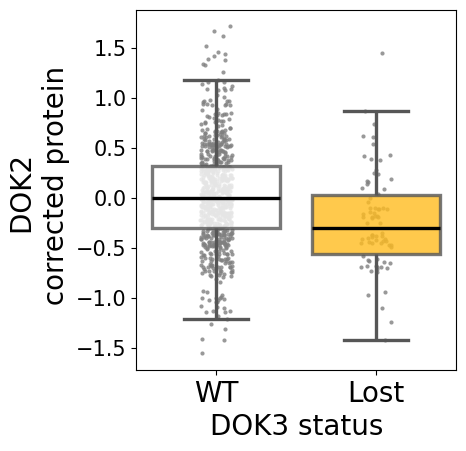

In [46]:
CPTAC_boxplot('DOK2_DOK3', prot_res, cptac_prot_minus_studycn, A2_lost, coldict, '\n corrected protein')

## Figure 3

In [49]:
overlaps_prot = pd.read_csv('../../output/output_CPTAC/prot/categorical_overlaps_prot.csv')
overlaps_trans = pd.read_csv('../../output/output_CPTAC/trans/categorical_overlaps_trans.csv')
overlaps_resid = pd.read_csv('../../output/output_CPTAC/prot_residual/categorical_overlaps_prot_residual.csv')

overlaps_prot['category'] = overlaps_prot.apply(lambda row: getcat(row['compensation'], row['collateral_loss']), axis=1)
overlaps_trans['category'] = overlaps_trans.apply(lambda row: getcat(row['compensation'], row['collateral_loss']), axis=1)
overlaps_resid['category'] = overlaps_resid.apply(lambda row: getcat(row['compensation'], row['collateral_loss']), axis=1)


In [51]:
annotated_res = pd.read_csv('../../output/output_CPTAC/prot/all_quantoverlaps_prot.csv')

In [52]:
combined_ttest_and_boxplot('sequence_identity', annotated_res, 'seqid', ylim=True, coldict=coldict, namedict=namedict)


NameError: name 'stats' is not defined

/tmp/ipykernel_312538/505825650.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['category'] = df2['category'].replace({'compensation': 'Compensation',
/tmp/ipykernel_312538/505825650.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['category'] = pd.Categorical(df2['category'], categories=category_order, ordered=True)
/tmp/ipykernel_312538/505825650.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` 

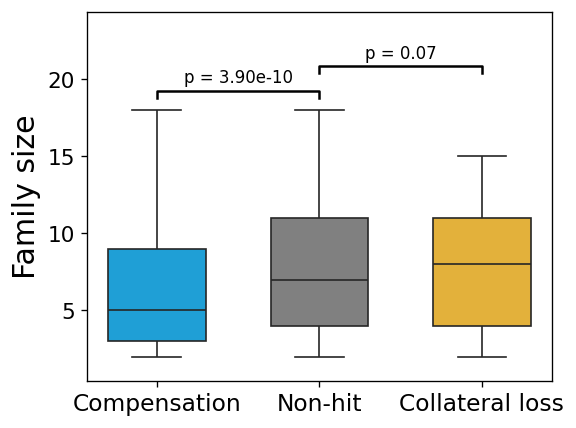

In [85]:
combined_ttest_and_boxplot('family_size', annotated_res, 'famsize', ylim=None, coldict=coldict, namedict=namedict)


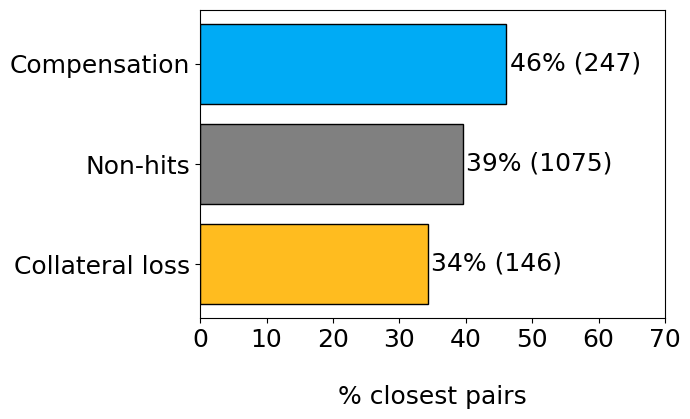

In [86]:
make_overlap_bar_chart(overlaps_prot, 'closest_pair', 70, '% closest pairs', colordictloc = coldict, filename = 'closestoverlap')


## Figure 4

/tmp/ipykernel_312538/505825650.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['category'] = df2['category'].replace({'compensation': 'Compensation',
/tmp/ipykernel_312538/505825650.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['category'] = pd.Categorical(df2['category'], categories=category_order, ordered=True)
/tmp/ipykernel_312538/505825650.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` 

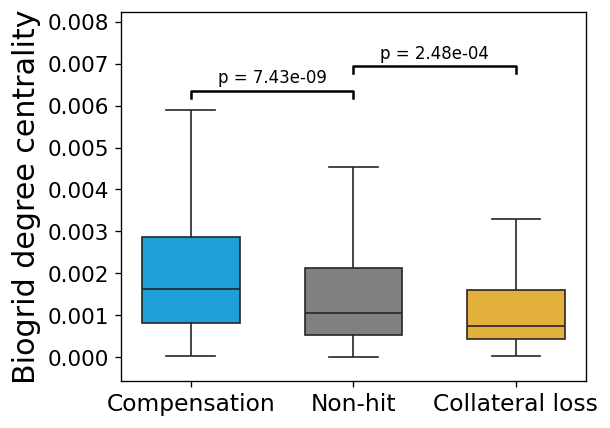

In [62]:
combined_ttest_and_boxplot('biogrid_dc', annotated_res, 'biogrid_dc', ylim=None, coldict=coldict, namedict=namedict)


/tmp/ipykernel_312538/505825650.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['category'] = df2['category'].replace({'compensation': 'Compensation',
/tmp/ipykernel_312538/505825650.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['category'] = pd.Categorical(df2['category'], categories=category_order, ordered=True)
/tmp/ipykernel_312538/505825650.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` 

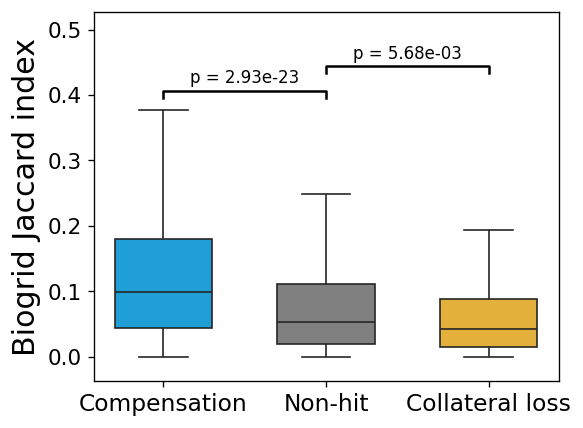

In [63]:
combined_ttest_and_boxplot('bg_jaccard', annotated_res, 'bg_jaccard', ylim=None, coldict=coldict, namedict=namedict)


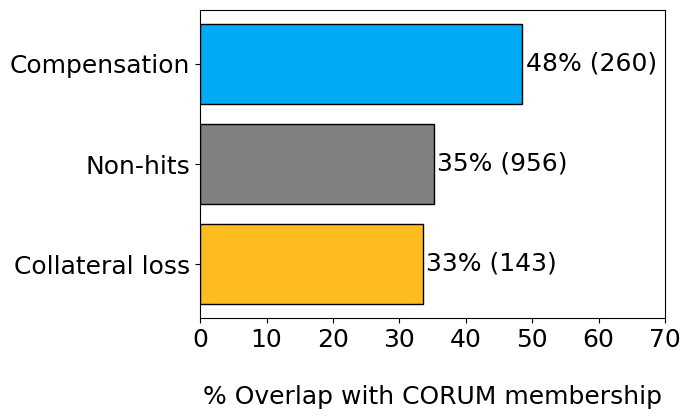

In [64]:
make_overlap_bar_chart(overlaps_prot, 'in_PC_CORUM', 70, '% Overlap with CORUM membership', colordictloc = coldict, filename = 'closestoverlap')


/tmp/ipykernel_312538/505825650.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['category'] = df2['category'].replace({'compensation': 'Compensation',
/tmp/ipykernel_312538/505825650.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['category'] = pd.Categorical(df2['category'], categories=category_order, ordered=True)
/tmp/ipykernel_312538/505825650.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` 

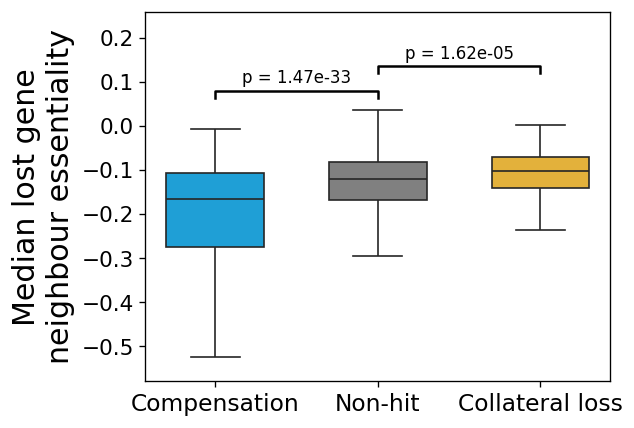

In [65]:
combined_ttest_and_boxplot('A2_median_neighbour_ess', annotated_res, 'A2_median_neighbour_ess', ylim=None, coldict=coldict, namedict=namedict)


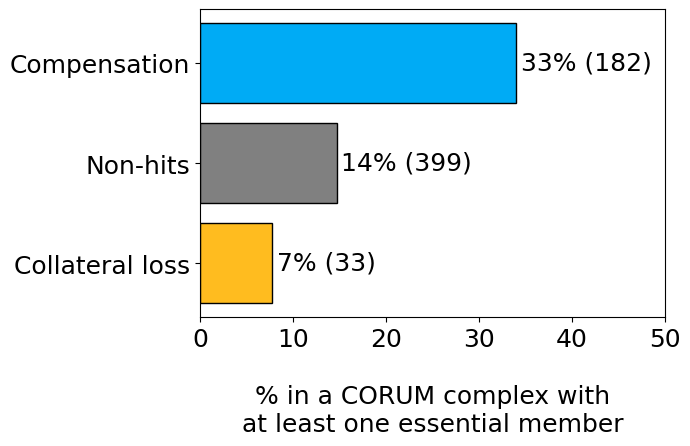

In [66]:
make_overlap_bar_chart(overlaps_prot, 'in_PC_CORUM_essential', 50, '% in a CORUM complex with\nat least one essential member', colordictloc = coldict, filename = 'closestoverlap')


/tmp/ipykernel_312538/505825650.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['category'] = df2['category'].replace({'compensation': 'Compensation',
/tmp/ipykernel_312538/505825650.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['category'] = pd.Categorical(df2['category'], categories=category_order, ordered=True)
/tmp/ipykernel_312538/505825650.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` 

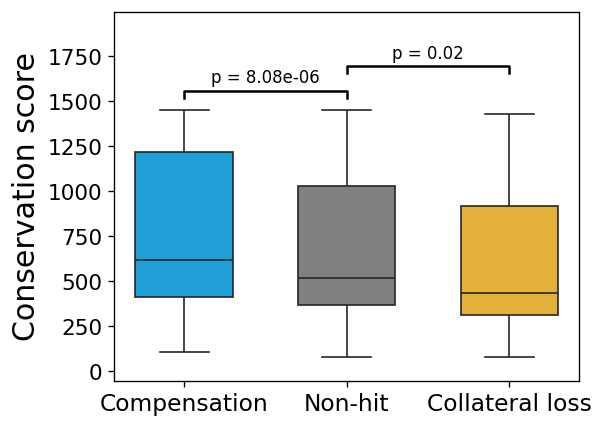

In [67]:
combined_ttest_and_boxplot('conservation_score', annotated_res, 'conservation_score', ylim=None, coldict=coldict, namedict=namedict)


## Figure 5

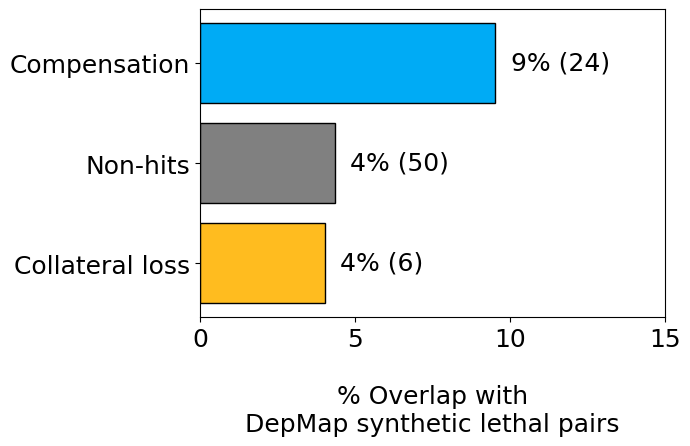

In [68]:
make_overlap_bar_chart(overlaps_prot, 'bronze_standard_SL', 15, '% Overlap with\nDepMap synthetic lethal pairs', colordictloc = coldict, filename = 'closestoverlap')


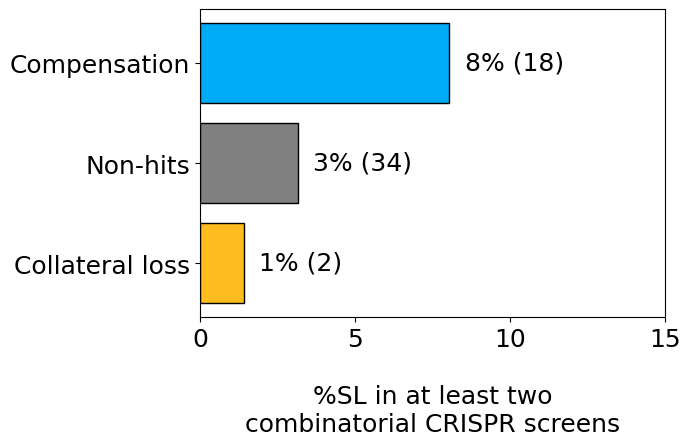

In [69]:
make_overlap_bar_chart(overlaps_prot, 'strict_comb_hit', 15, '%SL in at least two\ncombinatorial CRISPR screens', colordictloc = coldict, filename = 'closestoverlap')


In [70]:
# De Kegel et al 2021 results, processed to add sorted_gene_pair and gene_pair

CRISPR_results = pd.read_csv('../../data/for_overlap/CRISPR_SL_processed.csv').drop(columns = 'Unnamed: 0')
CRISPR_results[:2]

,sorted_gene_pair,A1,A2,A2_status_coef,A2_status_p,A2_status_p_adj,SL,A1_entrez,A2_entrez,A1_ensembl,A2_ensembl,gene_pair
0,AAK1_BMP2K,AAK1,BMP2K,-0.033329,0.445594,0.873493,False,22848,55589,ENSG00000115977,ENSG00000138756,AAK1_BMP2K
1,AAK1_BMP2K,BMP2K,AAK1,-0.059093,0.083675,NaN,False,55589,22848,ENSG00000138756,ENSG00000115977,BMP2K_AAK1


In [71]:
# Downloaded from HUGO Gene Nomenclature portal

mapping = pd.read_csv('../../data/general/geneidmap_sep24.txt', sep = '\t').rename(columns = {'Approved symbol':'gene_name','NCBI Gene ID(supplied by NCBI)':'entrez_id'})
mapping = mapping.dropna()
mapping['entrez_id'] = mapping['entrez_id'].astype(int)
mapping['entrez_id'] = mapping['entrez_id'].astype(str)
mapping.set_index('entrez_id', inplace = True)
mapping.index = mapping.index.astype(str)
def get_gene_name(entid):
    if entid in mapping.index:
        return mapping.loc[entid, 'gene_name']
    else:
        return np.nan
mapping[:2]

,gene_name,Ensembl ID(supplied by Ensembl),UniProt ID(supplied by UniProt)
entrez_id,,,
1,A1BG,ENSG00000121410,P04217
29974,A1CF,ENSG00000148584,Q9NQ94


In [72]:
# These annotations of which cell lines have lost genes in DepMap is obtained from running the analysis outlined in De Kegel et al 2021
# Loss is called based on the presence of a homozygous deletion (called using absolute copy number), mRNA expression below 1 log TPM,
# z-scored mRNA expression below -4, or the presence of a loss-of-function mutation

essentiality_lost = pd.read_csv('../../data/for_overlap/A2_lost_essentiality.csv').rename(columns = {'Unnamed: 0':'gene_name'}).set_index('gene_name')
essentiality_lost.index =essentiality_lost.index.astype(str)
essentiality_lost = essentiality_lost.reset_index()
essentiality_lost['gene_name'] = essentiality_lost['gene_name'].apply(get_gene_name)
essentiality_lost.dropna(subset = 'gene_name',inplace = True)
essentiality_lost =essentiality_lost.set_index('gene_name')
essentiality_lost.index = essentiality_lost.index.astype(str)
essentiality_lost[:2]

,ACH-000004,ACH-000005,ACH-000007,ACH-000009,ACH-000011,ACH-000012,ACH-000013,ACH-000014,ACH-000015,ACH-000017,...,ACH-001960,ACH-001997,ACH-001999,ACH-002001,ACH-002002,ACH-002003,ACH-002004,ACH-002005,ACH-002015,ACH-002016
gene_name,,,,,,,,,,,,,,,,,,,,,
POLR2B,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
APPL1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [73]:
# CERES scores reprocessed as outlined in De Kegel et al 2021

scores_filtered = pd.read_csv('../../data/for_overlap/scores_depmap.csv').set_index('cell_line')
scores_filtered.columns = scores_filtered.columns.map(lambda x: get_gene_name(x))
scores_filtered.columns = scores_filtered.columns.astype(str)
scores_filtered[:2]

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
cell_line,,,,,,,,,,,,,,,,,,,,,
ACH-001382,0.652347,-0.020793,-0.270112,-0.211408,0.06271,-0.081674,0.376840,-0.767385,0.166991,0.112045,...,0.182055,-0.724872,0.499652,-0.141164,-0.336501,0.250665,-0.676302,-0.098001,-0.677497,-0.506629
ACH-000250,-0.081394,0.093385,0.005231,0.158573,0.01236,-0.047724,0.133516,-0.478856,0.018642,0.085868,...,0.003926,-0.068262,-0.005768,-0.241775,0.000087,0.085940,-0.104364,-0.040344,-0.057078,-0.180227


/tmp/ipykernel_312538/4029397534.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=f'A1_{measure}', x='A2_lost', data=df, ax=ax,


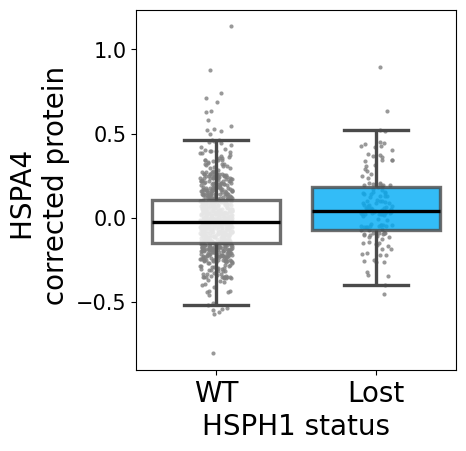

In [74]:
CPTAC_boxplot('HSPA4_HSPH1', prot_res, cptac_prot_minus_studycn, A2_lost, coldict, '\n corrected protein')

/tmp/ipykernel_312538/4029397534.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=f'A1_{measure}', x='A2_lost', data=df, ax=ax,


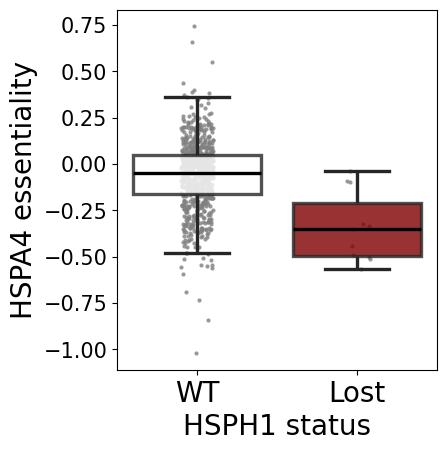

In [75]:
CPTAC_boxplot('HSPA4_HSPH1', CRISPR_results, scores_filtered, essentiality_lost, coldict, 'essentiality', ess=True)

/tmp/ipykernel_312538/4029397534.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=f'A1_{measure}', x='A2_lost', data=df, ax=ax,


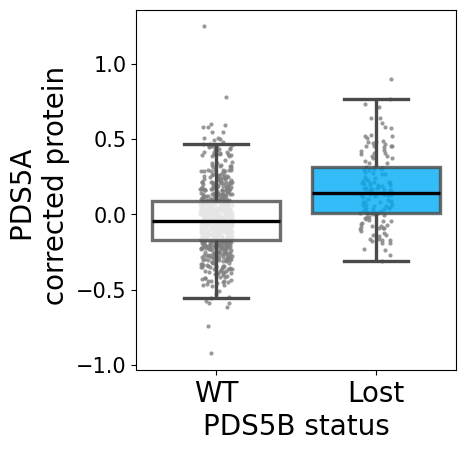

In [76]:
CPTAC_boxplot('PDS5A_PDS5B', prot_res, cptac_prot_minus_studycn, A2_lost, coldict, '\n corrected protein')

/tmp/ipykernel_312538/4029397534.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=f'A1_{measure}', x='A2_lost', data=df, ax=ax,


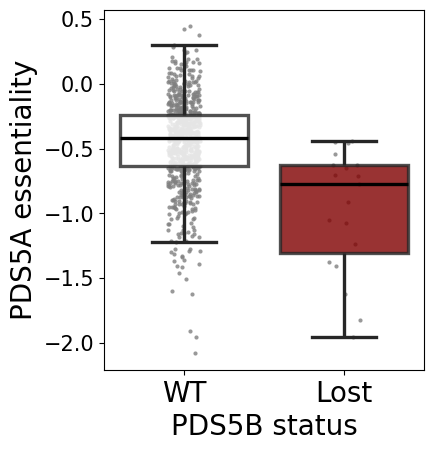

In [77]:
CPTAC_boxplot('PDS5A_PDS5B', CRISPR_results, scores_filtered, essentiality_lost, coldict, 'essentiality', ess=True)

## Figure 6

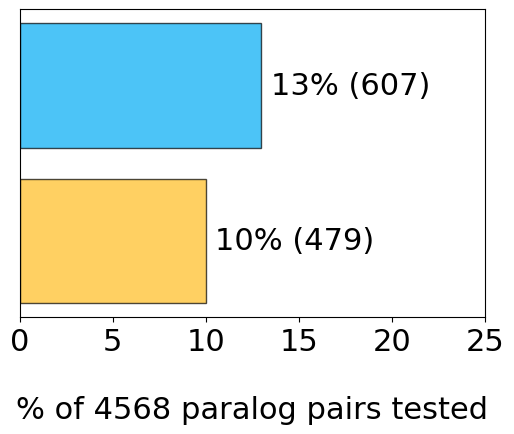

In [87]:
generate_comp_CL_barchart(trans_res, 'trans', colormap=coldict, xlim=25, yticks=False)


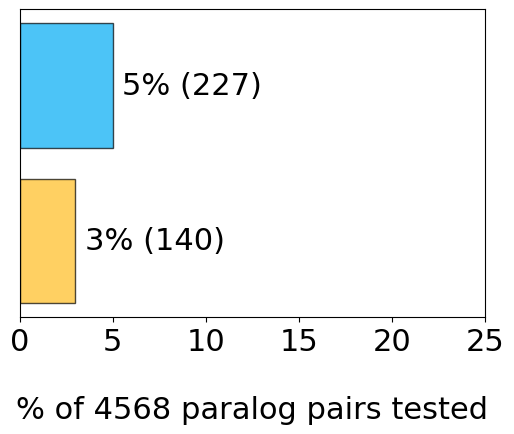

In [88]:
generate_comp_CL_barchart(resid_res, 'resid', colormap=coldict, xlim=25, yticks=False)


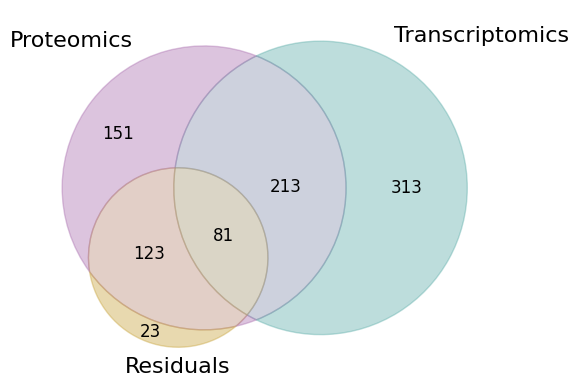

In [89]:
draw_venn(protcomp, transcomp, residcomp, 'comp')


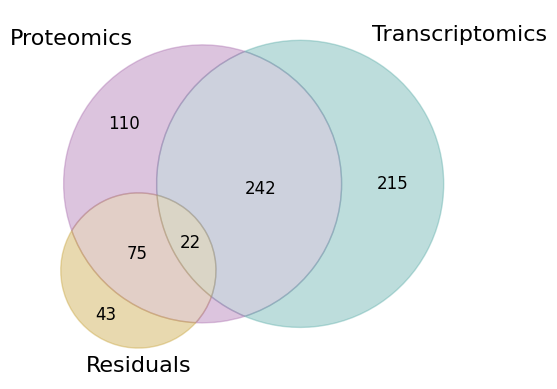

In [90]:
draw_venn(protcl, transcl, residcl, 'cl')

In [91]:
# More overlap than expected by chance? 

def perform_fet(tested_pairs, mrna_hits, protein_hits):
    tested_pairs_set = set(tested_pairs)
    mrna_hits_set = set(mrna_hits) & tested_pairs_set
    protein_hits_set = set(protein_hits) & tested_pairs_set
    hit_counts = Counter({
        'both': len(mrna_hits_set & protein_hits_set),
        'mrna_only': len(mrna_hits_set - protein_hits_set),
        'protein_only': len(protein_hits_set - mrna_hits_set),
        'neither': len(tested_pairs_set - mrna_hits_set - protein_hits_set)})

    contingency_table = np.array([
        [hit_counts['both'], hit_counts['protein_only']],
        [hit_counts['mrna_only'], hit_counts['neither']]])

    odds_ratio, p_value = fisher_exact(contingency_table)
    return odds_ratio, p_value

odds_ratio_comp, p_value_comp = perform_fet(prot_res.gene_pair.to_list(), transcomp, protcomp)
print('Compensation: ')
print(f"Odds Ratio: {odds_ratio_comp}")
print(f"P-value: {p_value_comp}")

odds_ratio_cl, p_value_cl = perform_fet(prot_res.gene_pair.to_list(), transcl, protcl)
print('\nCollateral loss: ')
print(f"Odds Ratio: {odds_ratio_cl}")
print(f"P-value: {p_value_cl}")


Compensation: 
Odds Ratio: 12.639374081761153
P-value: 1.0127384735635535e-131

Collateral loss: 
Odds Ratio: 25.912155876807038
P-value: 4.388840182165839e-169


In [92]:
cptac_trans_minus_studycn = pd.read_csv('../../data/CPTAC/trans_study_CN_resid.csv')
cptac_trans_minus_studycn = cptac_trans_minus_studycn.pivot(index='Sample', columns='Gene', values='Residuals')
cptac_trans_minus_studycn.index.name = 'sample_ID'
cptac_trans_minus_studycn.columns.name = ''
cptac_trans_minus_studycn[:2]

,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADAT,...,ZSWIM9,ZUP1,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
sample_ID,,,,,,,,,,,,,,,,,,,,,
01BR001,0.259596,-1.703801,-0.618369,0.437516,0.631434,-1.685448,-0.523951,0.078711,-0.737345,0.394205,...,-0.480171,0.058588,0.043056,-0.416663,-1.606906,-0.158185,-0.02671,-0.172086,-0.436222,-0.798603
01BR008,-0.350404,1.226899,-0.356683,4.898741,-1.020466,-0.003648,0.326549,-0.740146,-2.180945,1.629793,...,-0.071471,0.157488,0.062756,0.549814,1.555794,-0.108685,-1.35901,0.648414,-0.186122,-0.298303


In [93]:
cptac_resid = pd.read_csv('../../data/CPTAC/CPTAC_prot_residuals.csv').set_index('Sample')
cptac_resid.index.name = 'sample_ID'
cptac_resid[:2]

,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADAT,...,ZSWIM9,ZUP1,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
sample_ID,,,,,,,,,,,,,,,,,,,,,
01BR001,0.625387,NaN,0.608315,-0.852226,NaN,NaN,0.191040,0.003923,NaN,0.735036,...,NaN,NaN,-0.163533,0.609336,0.539669,1.268501,0.128450,0.227388,-0.589731,0.017713
01BR008,-0.482531,NaN,0.084366,-0.379444,NaN,NaN,0.126785,-0.371684,NaN,NaN,...,NaN,NaN,0.012110,0.086561,-0.258000,0.945699,0.145815,-0.426403,0.039320,0.196012


/tmp/ipykernel_312538/4029397534.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=f'A1_{measure}', x='A2_lost', data=df, ax=ax,


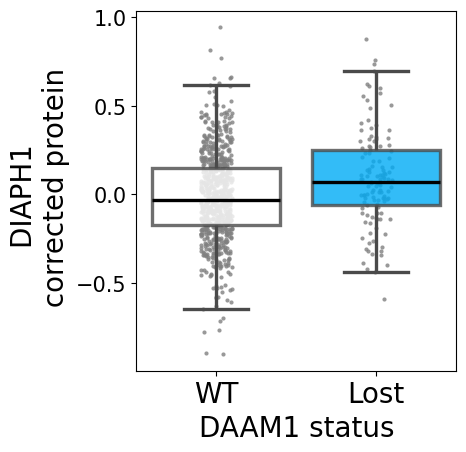

In [94]:
CPTAC_boxplot('DIAPH1_DAAM1', prot_res, cptac_prot_minus_studycn, A2_lost, coldict, '\n corrected protein')


/tmp/ipykernel_312538/4029397534.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=f'A1_{measure}', x='A2_lost', data=df, ax=ax,


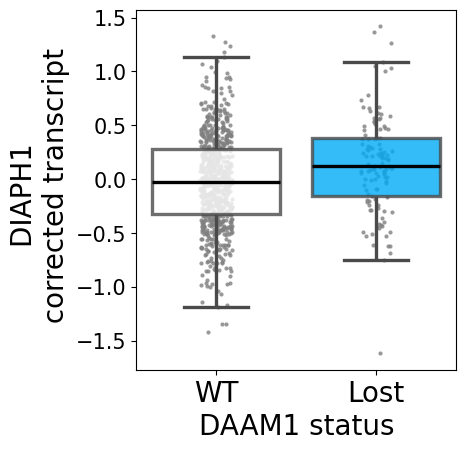

In [95]:
CPTAC_boxplot('DIAPH1_DAAM1', trans_res, cptac_trans_minus_studycn, A2_lost, coldict, '\n corrected transcript')


/tmp/ipykernel_312538/4029397534.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=f'A1_{measure}', x='A2_lost', data=df, ax=ax,


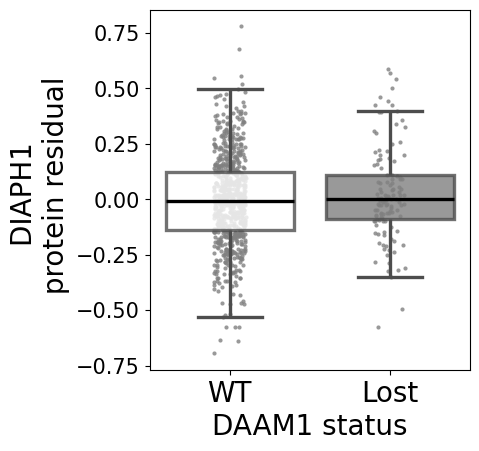

In [96]:
CPTAC_boxplot('DIAPH1_DAAM1', resid_res, cptac_resid, A2_lost, coldict, '\n protein residual')


/tmp/ipykernel_312538/4029397534.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=f'A1_{measure}', x='A2_lost', data=df, ax=ax,


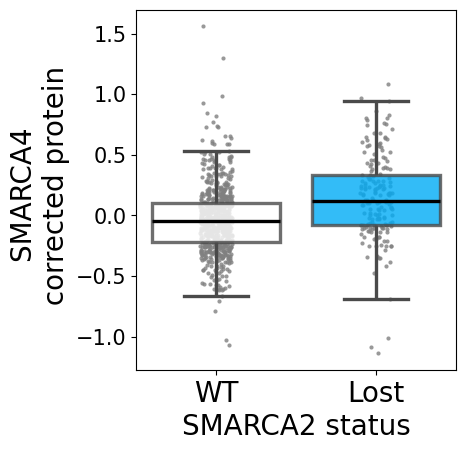

In [97]:
CPTAC_boxplot('SMARCA4_SMARCA2', prot_res, cptac_prot_minus_studycn, A2_lost, coldict, '\n corrected protein')


/tmp/ipykernel_312538/4029397534.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=f'A1_{measure}', x='A2_lost', data=df, ax=ax,


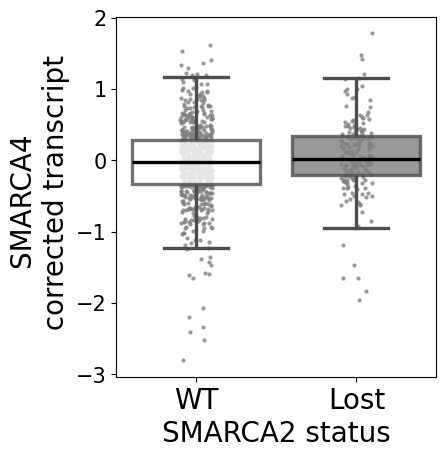

In [98]:
CPTAC_boxplot('SMARCA4_SMARCA2', trans_res, cptac_trans_minus_studycn, A2_lost, coldict, '\n corrected transcript')


/tmp/ipykernel_312538/4029397534.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=f'A1_{measure}', x='A2_lost', data=df, ax=ax,


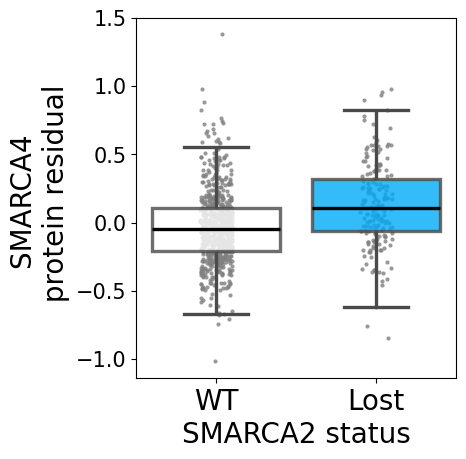

In [99]:
CPTAC_boxplot('SMARCA4_SMARCA2', resid_res, cptac_resid, A2_lost, coldict, '\n protein residual')


/tmp/ipykernel_312538/4029397534.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=f'A1_{measure}', x='A2_lost', data=df, ax=ax,


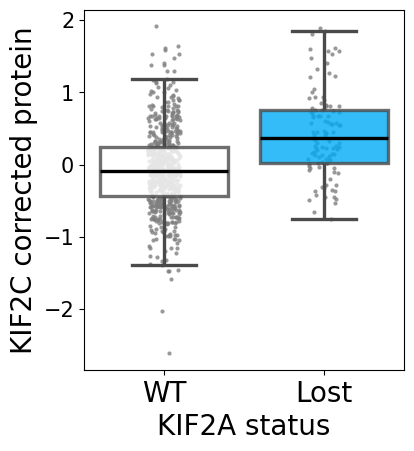

In [100]:
CPTAC_boxplot('KIF2C_KIF2A', prot_res, cptac_prot_minus_studycn, A2_lost, coldict, 'corrected protein')

/tmp/ipykernel_312538/4029397534.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=f'A1_{measure}', x='A2_lost', data=df, ax=ax,


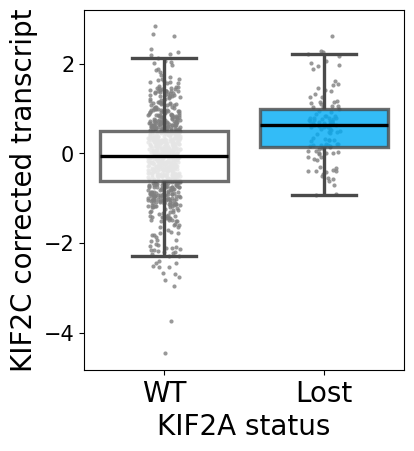

In [101]:
CPTAC_boxplot('KIF2C_KIF2A', trans_res, cptac_trans_minus_studycn, A2_lost, coldict, 'corrected transcript')

/tmp/ipykernel_312538/4029397534.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=f'A1_{measure}', x='A2_lost', data=df, ax=ax,


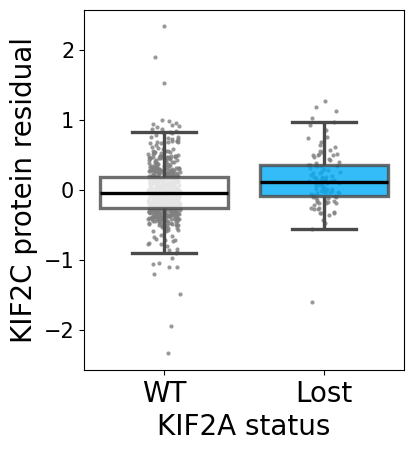

In [102]:
CPTAC_boxplot('KIF2C_KIF2A', resid_res, cptac_resid, A2_lost, coldict, 'protein residual')

In [103]:
fish_prot_sorted = pd.read_csv('../../output/output_CPTAC/prot/categorical_FETs_uniquegenepairs_prot.csv')
fish_trans_sorted = pd.read_csv('../../output/output_CPTAC/trans/categorical_FETs_uniquegenepairs_trans.csv')
fish_res_sorted = pd.read_csv('../../output/output_CPTAC/prot_residual/categorical_FETs_uniquegenepairs_prot_residual.csv')


In [104]:
ydict = {'in_PC_CORUM_both':'Both in same CORUM complex', 'strict_comb_hit':'Synthetic lethal in at least 2 CRISPR screens','in_PC_humap':'Either member in Humap complex','bronze_standard_SL':'DepMap synthetic lethal','lenient_comb_hit':'Synthetic lethal in at least one CRISPR screen', 'in_PC_EBI':'Either member in EBI ComplexPortal complex','in_PC_CORUM':'Either member in CORUM complex', 'famsize2':'Family size 2','interacting_pair':'Physically interacting', 'closest_pair':'Closest pair', 'WGD':'Whole genome duplicates', 'other_dir_comp':'Reciprocal compensation hit', 'other_dir_cl':'Reciprocal collateral loss hit', 'A1_never_ess': 'Compensating gene never essential', 'A2_never_ess':'Lost gene never essential', 'A1_sometimes_ess':'Compensating gene sometimes essential', 'A2_sometimes_ess':'Lost gene sometimes essential', 'A1_broadly_ess':'Compensating gene broadly essential', 'A2_broadly_ess':'Lost gene broadly essential', 'in_PC_CORUM_essential':'Either member in essential CORUM complex'}


/tmp/ipykernel_312538/1739197240.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sig'] = (df['FET_p'] < 0.05) & (df['FET_p_adj'] < FDR)
/tmp/ipykernel_312538/1739197240.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['index'] = df['interaction_dataset'] + '_' + df['hit_type']
/tmp/ipykernel_312538/1739197240.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

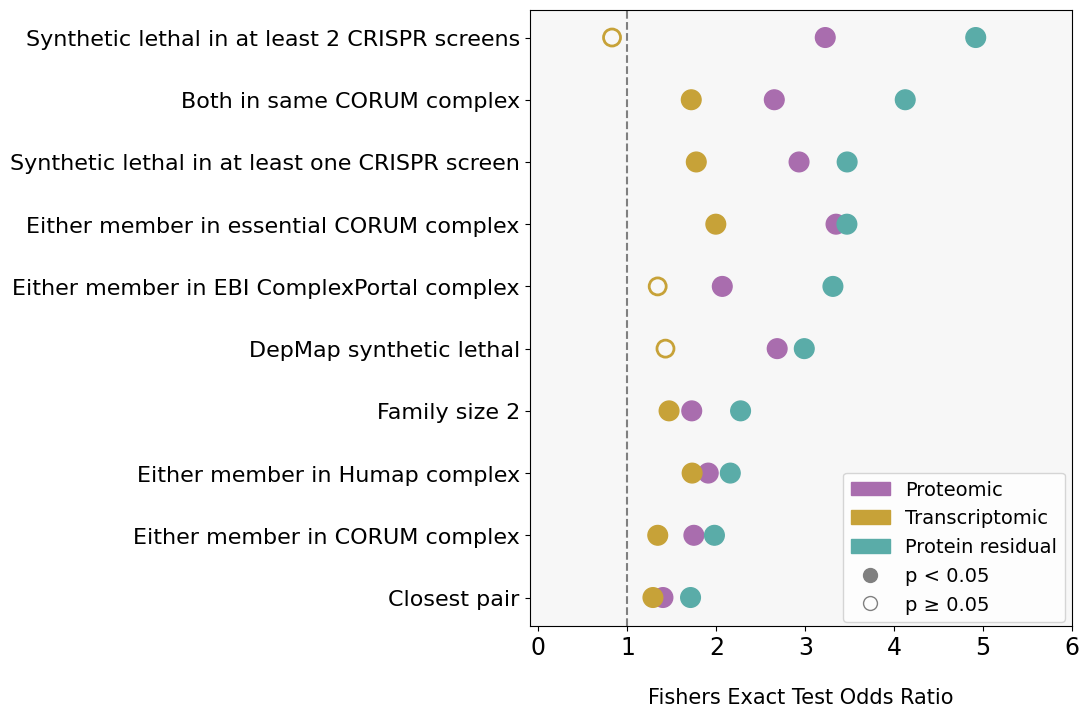

In [105]:
plot_OR('compensation', 0.05, fish_prot_sorted, df2=fish_trans_sorted,df3=fish_res_sorted, 
                    df1_label='Proteomic', df2_label='Transcriptomic', df3_label ='Protein residual', 
                    displaydf=False, ylabel_dict = ydict, rightxlim=6)


In [106]:
ub_sites = pd.read_csv('../../data/for_overlap/Ubiquitination_site_dataset', sep='\t')
ub_sites = ub_sites.dropna(subset='GENE')
ub_sites.GENE = ub_sites.GENE.astype(str).apply(lambda x: x.upper())
ubdict = ub_sites.GENE.value_counts().to_dict()
ub_sites[:2]

/tmp/ipykernel_312538/4061233908.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  ub_sites = pd.read_csv('../../data/for_overlap/Ubiquitination_site_dataset', sep='\t')


,GENE,PROTEIN,ACC_ID,HU_CHR_LOC,MOD_RSD,SITE_GRP_ID,ORGANISM,MW_kD,DOMAIN,SITE_+/-7_AA,LT_LIT,MS_LIT,MS_CST,CST_CAT#,Ambiguous_Site
0,YWHAB,14-3-3 beta,P31946,20q13.12,K5-ub,41481400,human,28.08,NaN,___MtMDksELVQkA,NaN,4.0,NaN,NaN,0
1,YWHAB,14-3-3 beta,P31946,20q13.12,K11-ub,4953847,human,28.08,14-3-3,DksELVQkAkLAEQA,NaN,7.0,26.0,NaN,0


In [107]:
all_corum = pd.read_csv('../../data/for_overlap/corum_with_symbols_nov23.csv', index_col = 0)
all_corum[:2]

,gene_symbol,complex
0,ABCF2,SNW1 complex
1,MATR3,p54(nrb)-PSF-matrin3 complex


In [111]:
prot_tested = prot_res.gene_pair.to_list()
all_comp_union = list(np.union1d(np.union1d(protcomp, transcomp), residcomp))
all_cl_union = list(np.union1d(np.union1d(protcl, transcl), residcl))
all_hits_union = list(np.union1d(all_comp_union, all_cl_union))
never_hits = np.setdiff1d(prot_tested, all_hits_union)

prot_res['post_trans_forplot'] = prot_res['gene_pair'].apply(lambda x: get_postransreg_for_plot(x, residcomp, protcomp, transcomp, never_hits))

all_corum_prots = list(set(all_corum.gene_symbol.to_list()))
all_tested_A1s = prot_res.A1.to_list()
all_corum_prots = [x for x in all_corum_prots if x in all_tested_A1s]

complex_sizes = get_complex_sizes(all_corum_prots, all_corum)
big_complex_prots = list({k:v for k,v in complex_sizes.items() if v > 10}.keys())
not_corum_prots = list(np.setdiff1d(prot_res.A1.to_list(), all_corum_prots))
all_post_trans_A1s = list(set(prot_res[prot_res.post_trans_forplot == 'post_trans'].A1.to_list()))
all_trans_A1s = list(set(prot_res[prot_res.post_trans_forplot == 'trans'].A1.to_list()))
all_non_hit_A1s = list(set(prot_res[prot_res.post_trans_forplot == 'non_hit'].A1.to_list()))

In [112]:
ubsite_df = create_ubsite_df(not_corum_prots, all_corum_prots, big_complex_prots, all_post_trans_A1s, all_trans_A1s, all_non_hit_A1s, ubdict)
ubsite_df[:2]

,Protein,Category,num_ub_sites
0,A2ML1,Not\nin CORUM,0
1,AAK1,Not\nin CORUM,5


In [113]:
category_order = ['CORUM\ncomplex\nsize >10', 'In\nCORUM', 'Post-trans\ncomp', 'Non-hits', 'Trans comp', 'Not\nin CORUM']

In [117]:
category_order = ['CORUM\ncomplex\nsize >10', 'In\nCORUM', 'Post-trans\ncomp', 'Non-hits', 'Trans\ncomp', 'Not\nin CORUM']

ub_color_dict = {
    'CORUM\ncomplex\nsize >10': 'white',
    'In\nCORUM': 'white',
    'Post-trans\ncomp': '#5AACA8',
    'Trans\ncomp': '#C7A238',
    'Non-hits': '#999999ff',
    'Not\nin CORUM': 'white'
}


/tmp/ipykernel_312538/1510086720.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Category', y='num_ub_sites', data=ubsite_df,
/tmp/ipykernel_312538/1510086720.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(category_order, rotation=0, ha='center')


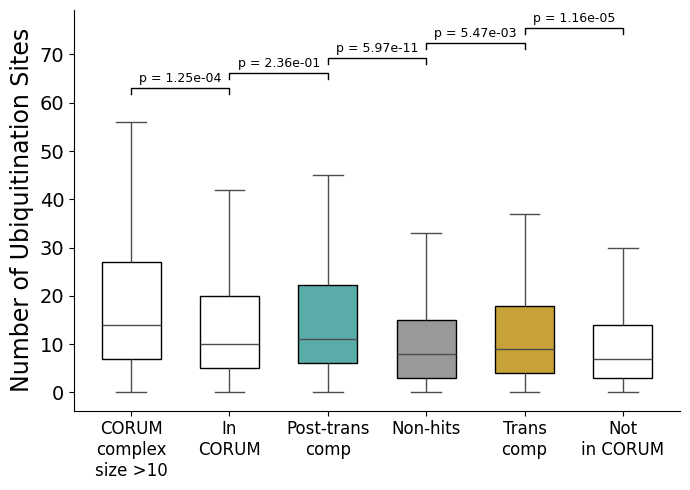

In [118]:
plot_ubiquitination_sites(ubsite_df, category_order, color_dict=ub_color_dict, add_p_values=True, save=False)

/tmp/ipykernel_312538/1510086720.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Category', y='num_ub_sites', data=ubsite_df,
/tmp/ipykernel_312538/1510086720.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(category_order, rotation=0, ha='center')


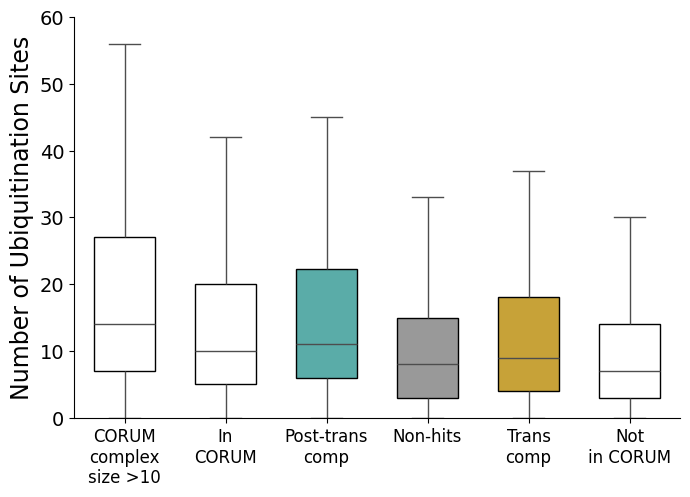

In [119]:
plot_ubiquitination_sites(ubsite_df, category_order, color_dict=ub_color_dict, add_p_values=False, save=True)

In [120]:
# Figure 7 created in Inkscape

## Supplementary Figure 1

In [121]:
results_A2 = pd.read_csv('../../output/output_CPTAC/prot/self_tests_prot.csv')

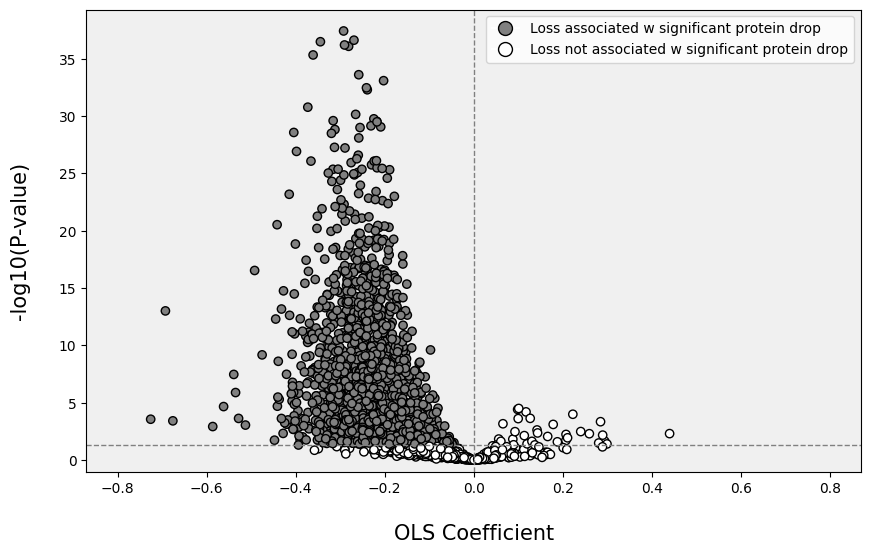

In [122]:
make_volcano_plot(results_A2, 'prot', 0.05, colordict=coldict, xlim=False, A2=True)


In [123]:
# We only correct for study when doing the self-tests, so we have a separate set of residuals for these plots

prot_minus_study_only = pd.read_csv('../../data/CPTAC/prot_study_resid.csv')
prot_minus_study_only = prot_minus_study_only.pivot(index='Sample', columns='Gene', values='Residuals')
prot_minus_study_only.index.name = 'sample_ID'
prot_minus_study_only.columns.name = ''
prot_minus_study_only[:2]

,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADAT,...,ZSWIM9,ZUP1,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
sample_ID,,,,,,,,,,,,,,,,,,,,,
01BR001,0.631365,NaN,0.497650,-0.744488,NaN,NaN,0.137513,-0.170032,NaN,0.946434,...,NaN,NaN,-0.118403,0.223218,-0.085294,1.194652,0.132908,0.180199,-0.638268,-0.081942
01BR008,-0.491467,NaN,0.006215,1.643444,NaN,NaN,0.164991,-0.842962,NaN,NaN,...,NaN,NaN,0.061955,0.404109,0.333653,0.887891,-0.141726,-0.279733,0.033003,0.160646


In [124]:
# Makes life easier, none of these args change across plots except gene

def make_A2A2plot(gene, res = prot_res, prot = prot_minus_study_only, lost = A2_lost, cols = coldict):
    CPTAC_boxplot(f'{gene}_{gene}', res, prot, lost, cols, 'protein', plottingA2= True)


/tmp/ipykernel_312538/4029397534.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=f'A1_{measure}', x='A2_lost', data=df, ax=ax,


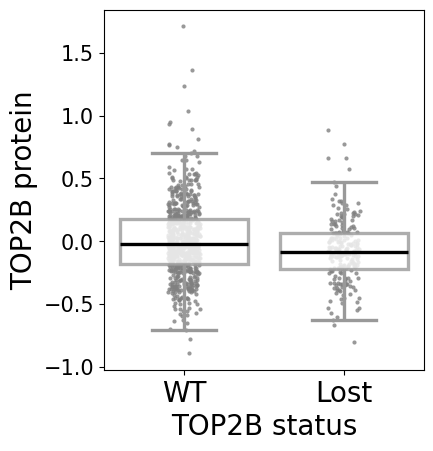

In [125]:
make_A2A2plot('TOP2B')

/tmp/ipykernel_312538/4029397534.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=f'A1_{measure}', x='A2_lost', data=df, ax=ax,


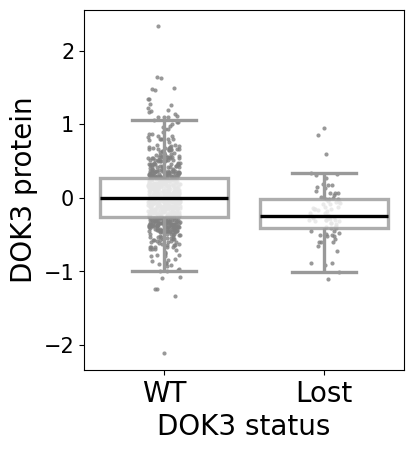

In [126]:
make_A2A2plot('DOK3')

/tmp/ipykernel_312538/4029397534.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=f'A1_{measure}', x='A2_lost', data=df, ax=ax,


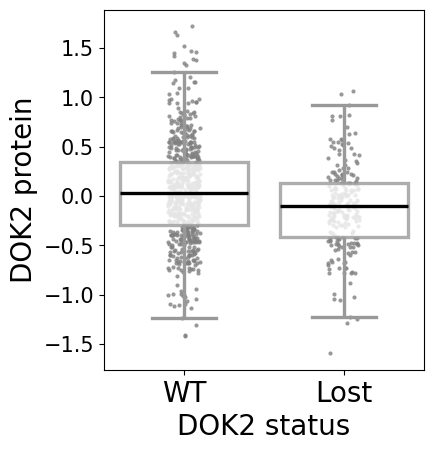

In [127]:
make_A2A2plot('DOK2')

/tmp/ipykernel_312538/4029397534.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=f'A1_{measure}', x='A2_lost', data=df, ax=ax,


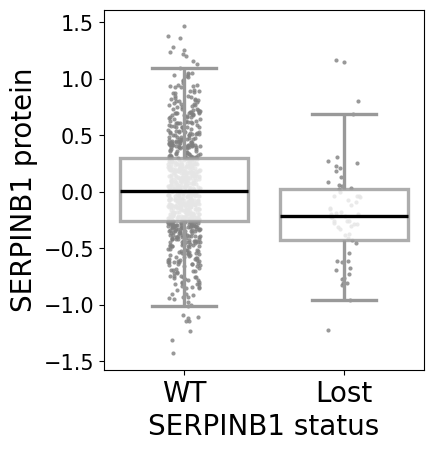

In [128]:
make_A2A2plot('SERPINB1')

/tmp/ipykernel_312538/4029397534.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=f'A1_{measure}', x='A2_lost', data=df, ax=ax,


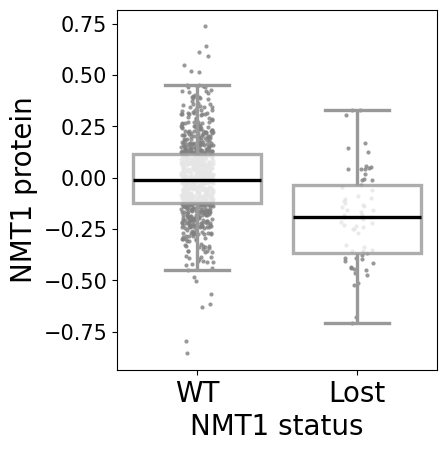

In [129]:
make_A2A2plot('NMT1')

/tmp/ipykernel_312538/4029397534.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=f'A1_{measure}', x='A2_lost', data=df, ax=ax,


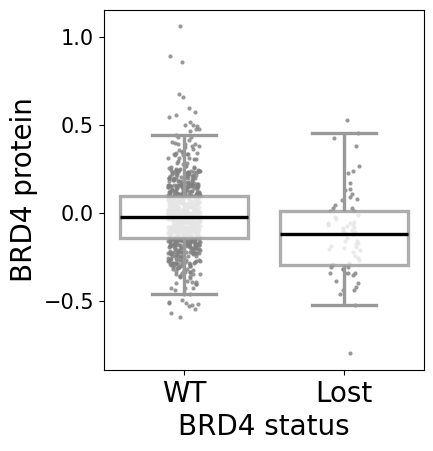

In [130]:
make_A2A2plot('BRD4')

/tmp/ipykernel_312538/4029397534.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=f'A1_{measure}', x='A2_lost', data=df, ax=ax,


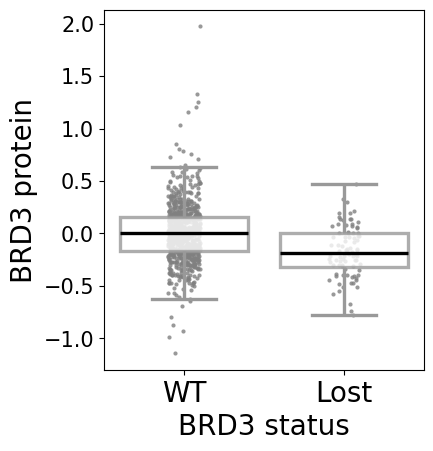

In [131]:
make_A2A2plot('BRD3')

In [132]:
# Supplementary Figure 2 created in Inkscape- check output dir for relevant numbers (pairs_filtered_at_each_step)

## Supplementary Figure 3

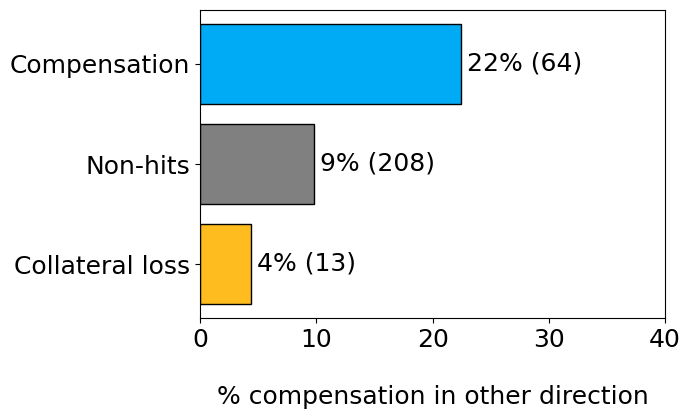

In [133]:
make_overlap_bar_chart(overlaps_prot, 'other_dir_comp', 40, '% compensation in other direction', colordictloc = coldict, filename = 'recip_comp', directional = True)


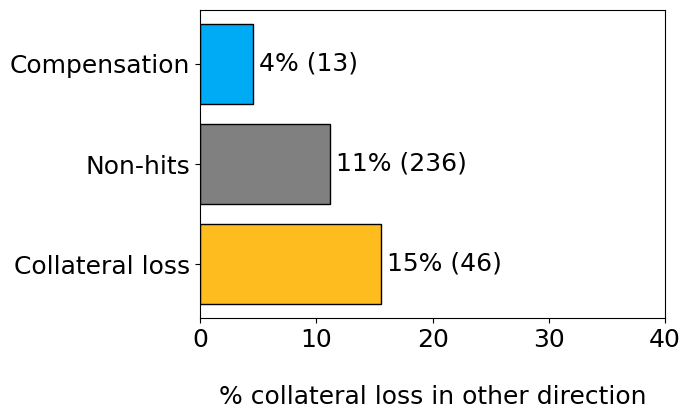

In [134]:
make_overlap_bar_chart(overlaps_prot, 'other_dir_cl', 40, '% collateral loss in other direction', colordictloc = coldict, filename = 'recip_cl', directional = True)


## Supplementary Figure 4

/tmp/ipykernel_312538/505825650.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['category'] = df2['category'].replace({'compensation': 'Compensation',
/tmp/ipykernel_312538/505825650.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['category'] = pd.Categorical(df2['category'], categories=category_order, ordered=True)
/tmp/ipykernel_312538/505825650.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` 

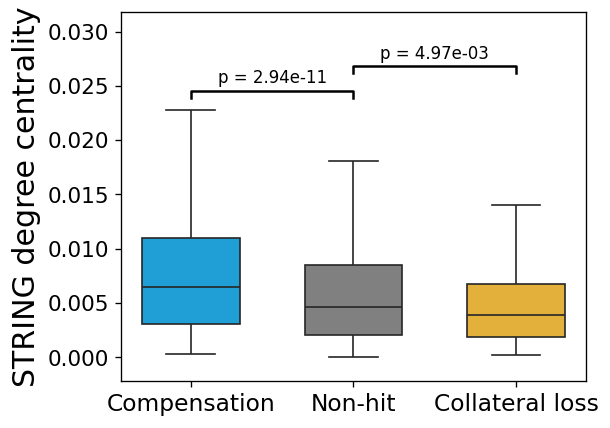

In [135]:
combined_ttest_and_boxplot('string_dc_physical', annotated_res, 'string_dc', ylim=None, coldict=coldict, namedict=namedict)


/tmp/ipykernel_312538/505825650.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['category'] = df2['category'].replace({'compensation': 'Compensation',
/tmp/ipykernel_312538/505825650.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['category'] = pd.Categorical(df2['category'], categories=category_order, ordered=True)
/tmp/ipykernel_312538/505825650.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` 

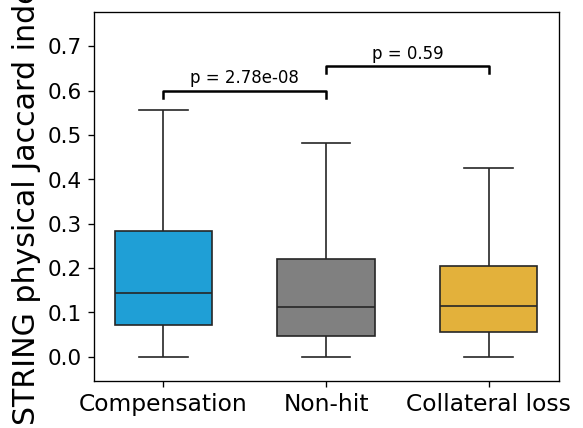

In [136]:
combined_ttest_and_boxplot('string_jaccard_physical', annotated_res, 'string_jaccard', ylim=None, coldict=coldict, namedict=namedict)


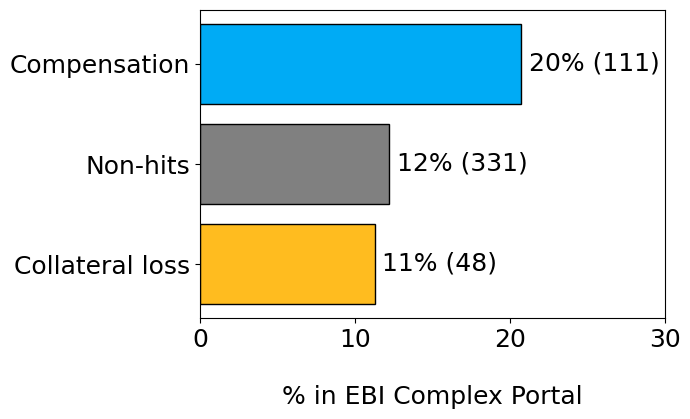

In [137]:
make_overlap_bar_chart(overlaps_prot, 'in_PC_EBI', 30, '% in EBI Complex Portal', colordictloc = coldict, filename = 'ebi')


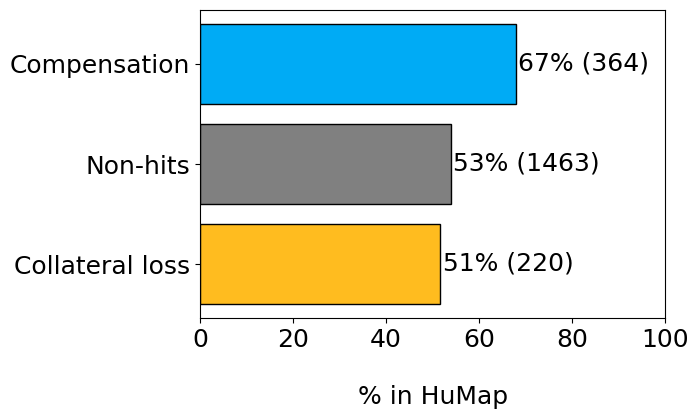

In [138]:
make_overlap_bar_chart(overlaps_prot, 'in_PC_humap', 100, '% in HuMap', colordictloc = coldict, filename = 'humap')


## Supplementary Figure 5

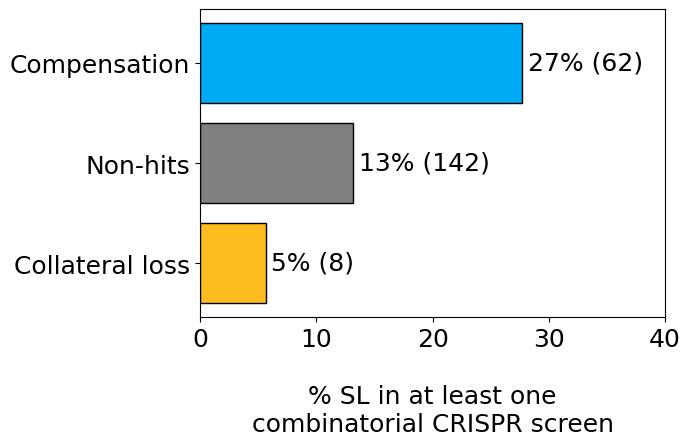

In [139]:
make_overlap_bar_chart(overlaps_prot, 'lenient_comb_hit', 40, '% SL in at least one\ncombinatorial CRISPR screen', colordictloc = coldict, filename = 'lenientSL')


In [140]:
# Supplementary Figure 6 created in Inkscape

## Supplementary Figure 7

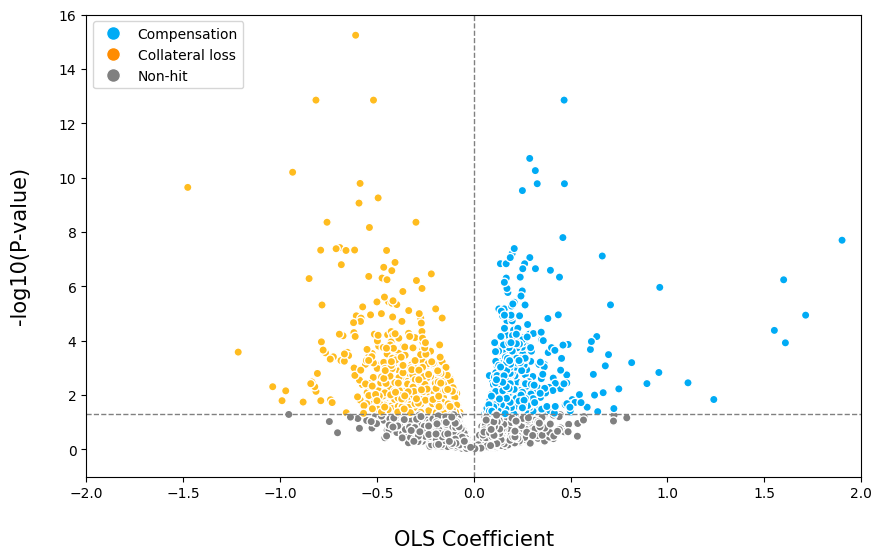

In [141]:
make_volcano_plot(trans_res, filename = 'trans', sigcutoff = 0.05, colordict = coldict)


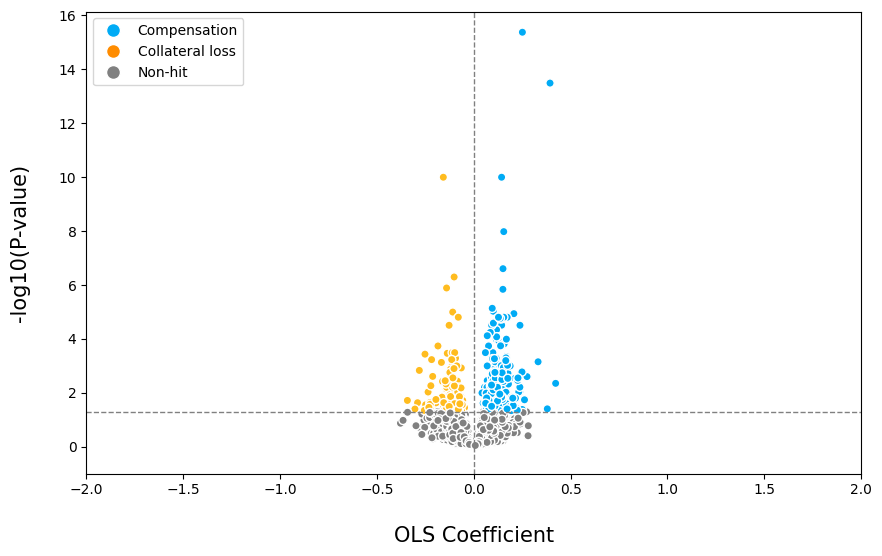

In [142]:
make_volcano_plot(resid_res, filename = 'resid', sigcutoff = 0.05, colordict = coldict)
